# Credit Risk Scorecard and Credit Scoring System

This project focused on developing a credit risk scorecard and credit scoring system using Lending Club data, with the goal of predicting loan defaults in a way that is accurate, interpretable, and aligned with banking industry standards.

To ensure practical application, I engineered the dataset by removing post-approval variables and transforming key features using **Weight of Evidence (WoE)** to preserve the monotonic relationship with default risk. Features were selected using a mix of model-based importance scores and domain knowledge. I handled class imbalance through resampling and trained a logistic regression model to estimate default probabilities.

These predicted probabilities were then converted into **credit scores**, assigning each borrower a score that reflects their likelihood of default in a standardized way. This makes it easier for credit teams to segment risk, automate approval decisions, and align lending strategy with portfolio objectives. I also transformed the model output into a structured scorecard, where each borrower’s score is broken down into points based on specific features (e.g., loan purpose, income level, credit history). This format is widely used in banks and credit bureaus because it provides **transparency**, **consistency**, and **explainability**—key requirements for both internal risk oversight and external regulations.

By presenting risk in this interpretable format, the scorecard helps ensure **fair lending practices** (e.g., under **ECOA**) and supports compliance with **Basel III** expectations around model governance and capital adequacy. It also enables practical integration into **loan underwriting systems, credit decision engines**, and **risk-based pricing frameworks**, all of which are critical in today’s **data-driven lending environments**.

The final output included:

- A full scorecard showing variable-level contributions to the score

- Individual credit scores for both training and test borrowers

- Visualizations of credit score distributions and variable impacts using WoE

- ROC and precision-recall curves to evaluate model performance and generalization

This project demonstrates how **machine learning and traditional credit scoring techniques** can work together to build a scalable, interpretable, and regulator-ready credit risk system. The approach reflects the practical needs of credit bureaus, banks, and lending institutions where accuracy, transparency, and compliance are critical to responsible lending.



In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.formula.api as smf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, average_precision_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer, balanced_accuracy_score
)


import warnings
warnings.filterwarnings('ignore')

In [244]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 70% !important; }</style>"))

In [245]:
df = pd.read_csv('financial_loan.csv')
df

,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38571,803452,NJ,INDIVIDUAL,< 1 year,Joseph M Sanzari Company,C,MORTGAGE,11-07-2021,16-05-2021,16-05-2021,...,C1,60 months,Verified,100000.0,0.1986,551.64,0.1299,24250,33,31946
38572,970377,NY,INDIVIDUAL,8 years,Swat Fame,C,RENT,11-10-2021,16-04-2021,16-05-2021,...,C1,60 months,Verified,50000.0,0.0458,579.72,0.1349,25200,18,31870
38573,875376,CA,INDIVIDUAL,5 years,Anaheim Regional Medical Center,D,RENT,11-09-2021,16-05-2021,16-05-2021,...,D5,60 months,Verified,65000.0,0.1734,627.93,0.1749,25000,20,35721
38574,972997,NY,INDIVIDUAL,5 years,Brooklyn Radiology,D,RENT,11-10-2021,16-05-2021,16-05-2021,...,D5,60 months,Verified,368000.0,0.0009,612.72,0.1825,24000,9,33677


In [4]:
df.columns.tolist()

['id',
 'address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'issue_date',
 'last_credit_pull_date',
 'last_payment_date',
 'loan_status',
 'next_payment_date',
 'member_id',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

In [6]:
df.describe()

,id,member_id,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
count,3.857600e+04,3.857600e+04,3.857600e+04,38576.000000,38576.000000,38576.000000,38576.000000,38576.000000,38576.000000
mean,6.810371e+05,8.476515e+05,6.964454e+04,0.133274,326.862965,0.120488,11296.066855,22.132544,12263.348533
std,2.113246e+05,2.668105e+05,6.429368e+04,0.066662,209.092000,0.037164,7460.746022,11.392282,9051.104777
min,5.473400e+04,7.069900e+04,4.000000e+03,0.000000,15.690000,0.054200,500.000000,2.000000,34.000000
25%,5.135170e+05,6.629788e+05,4.150000e+04,0.082100,168.450000,0.093200,5500.000000,14.000000,5633.000000
50%,6.627280e+05,8.473565e+05,6.000000e+04,0.134200,283.045000,0.118600,10000.000000,20.000000,10042.000000
75%,8.365060e+05,1.045652e+06,8.320050e+04,0.185900,434.442500,0.145900,15000.000000,29.000000,16658.000000
max,1.077501e+06,1.314167e+06,6.000000e+06,0.299900,1305.190000,0.245900,35000.000000,90.000000,58564.000000


### Converting dates to ``datatype``

In this dataset, there are some features showing some dates. Now, we convert those feature to ``datetype``. Also, we add the month of issuing the loan to a new feature.

In [7]:
df['issue_date'] = pd.to_datetime(df['issue_date'], format="%d-%m-%Y")
df['last_credit_pull_date'] = pd.to_datetime(df['last_credit_pull_date'], format="%d-%m-%Y")
df['last_payment_date'] = pd.to_datetime(df['last_payment_date'], format="%d-%m-%Y")
df['issue_month'] = df['issue_date'].dt.month


### Distribution of ``loan_status``

Based on the following graph, most of loans are fully paid, and around 13% of observations correspond to ``Charged Off``. 

Since we are going to predict the probability of default, we remove observations with ``Current`` as the ``loan_status``.

In [8]:
df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.833290
Charged Off    0.138247
Current        0.028463
Name: proportion, dtype: float64

<Axes: xlabel='loan_status', ylabel='percent'>

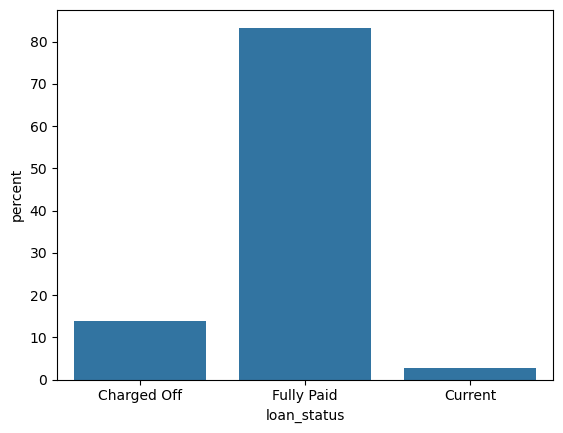

In [9]:
sns.countplot(df,x='loan_status', stat='percent')

Since we want to predict if a loan will be fully paid or defaulted, I remove observations corresponding to ``Current``.

In [10]:
df = df[df['loan_status']!='Current']
df = df.sort_values('issue_date', ascending=True)
df = df.reset_index(drop=True)
df.shape

(37478, 25)

Now, I convert ``loan_status`` to a binary variable which takes 1 if the load is defaulted (``Charged Off``) and it is fully paid, it will take 0.

In [11]:
df['defaulted'] = (df['loan_status'] == 'Charged Off').astype(int)

<Axes: xlabel='loan_status', ylabel='percent'>

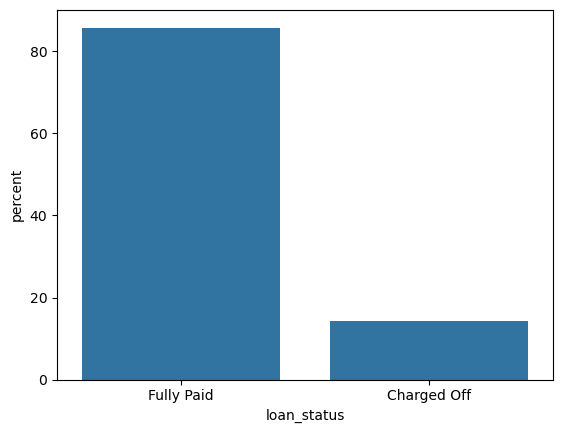

In [12]:
sns.countplot(df,x='loan_status', stat='percent')

### Train and Test Split

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['loan_status'])
train_cp = train.copy()

In [14]:
train['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.857715
Charged Off    0.142285
Name: proportion, dtype: float64

In [15]:
test['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.857657
Charged Off    0.142343
Name: proportion, dtype: float64

In [16]:
all_features = df.columns.tolist()
all_features

['id',
 'address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'issue_date',
 'last_credit_pull_date',
 'last_payment_date',
 'loan_status',
 'next_payment_date',
 'member_id',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment',
 'issue_month',
 'defaulted']

## Features for Predicting the Probability of Default

Based on the current dataset, there are several features which can be used for default prediction. Some features are irrelevant and can be removed. Also, there are some features that will be observed after predicting the proability of default and at the time of prediciton, those features are not available. Therefore, we need to remove them.

**Irrelevant Features**

- ``id``: 	Identifiers only — no predictive value
- ``member_id``: 	Identifiers only — no predictive value
- ``last_credit_pull_date``: Often occurs after approval — not known at origination
- ``last_payment_date``: Post-loan feature — leaks repayment behavior
- ``next_payment_date``: Future event — not available at origination.
- ``total_payment``: Reveals performance — direct leakage.
- ``issue_date``: Instead I will use ``issue_month``.

In [17]:
pd_to_remove = ['id', 'member_id', 'issue_date', 'last_credit_pull_date', 'last_payment_date',
               'next_payment_date', 'total_payment']

In [18]:
pd_features = df.drop(columns = pd_to_remove).columns.tolist()
pd_features

['address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'issue_month',
 'defaulted']

In [19]:
df[pd_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37478 entries, 0 to 37477
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   address_state        37478 non-null  object 
 1   application_type     37478 non-null  object 
 2   emp_length           37478 non-null  object 
 3   emp_title            36072 non-null  object 
 4   grade                37478 non-null  object 
 5   home_ownership       37478 non-null  object 
 6   loan_status          37478 non-null  object 
 7   purpose              37478 non-null  object 
 8   sub_grade            37478 non-null  object 
 9   term                 37478 non-null  object 
 10  verification_status  37478 non-null  object 
 11  annual_income        37478 non-null  float64
 12  dti                  37478 non-null  float64
 13  installment          37478 non-null  float64
 14  int_rate             37478 non-null  float64
 15  loan_amount          37478 non-null 

In [20]:
num_features = df[pd_features].select_dtypes('number').columns.tolist()
cat_features = df[pd_features].select_dtypes('object').columns.tolist()
cat_features

['address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']

### emp_length

``emp_length`` is a categorical variable. For simpler analysis, we convert it to numerical values.

In [21]:
df['emp_length'].unique()

array(['9 years', '10+ years', '4 years', '< 1 year', '2 years',
       '3 years', '1 year', '6 years', '8 years', '7 years', '5 years'],
      dtype=object)

In [22]:
def map_emp_length(df):
    emp_length_map = {
        '< 1 year': 0,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
    }

    df_mapped = df.copy()
    if 'emp_length' in df_mapped.columns:
        df_mapped['emp_length'] = df_mapped['emp_length'].map(emp_length_map)

    return df_mapped


train = map_emp_length(train)
train_cp = map_emp_length(train_cp)
test = map_emp_length(test)

## Removing some features

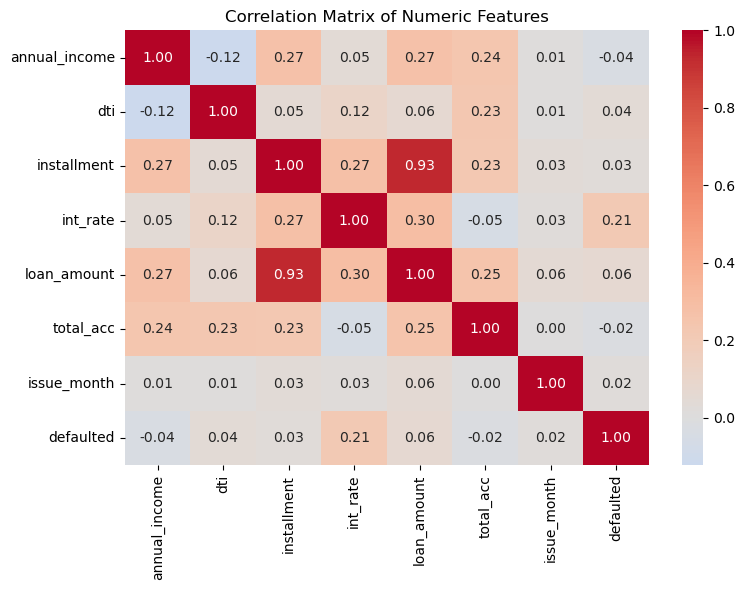

In [23]:
correlation_matrix = train_cp[num_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

``loan_amount`` and ``installment`` are highly correlated and we can remove one of them. I keep ``installment`` because:

- **More comprehensive**: ``installment`` encodes not just the loan amount, but also the term and interest rate, which both affect repayment pressure.
- **Directly related to affordability**: It represents the actual monthly burden on the borrower, which matters more when assessing repayment risk.

In [24]:
if 'loan_amount' in num_features:
    num_features.remove('loan_amount')


### Categorical Features

Here, I use **Entropy** and **Gini Index** to asses the distribution of categorical features. As the results show, there is no value in including ``application_type``. Also, ``emp_title`` has high cardinality and can be removed.

In [25]:
def feature_entropy(series):
    probs = series.value_counts(normalize=True)  
    return entropy(probs, base=2)  
    
for col in cat_features:
    entropy_value = feature_entropy(train_cp[col])
    print(f"Entropy of {col}: {entropy_value:.4f}")

Entropy of address_state: 4.5800
Entropy of application_type: 0.0000
Entropy of emp_length: 3.2484
Entropy of emp_title: 14.1009
Entropy of grade: 2.3393
Entropy of home_ownership: 1.3272
Entropy of loan_status: 0.5902
Entropy of purpose: 2.6468
Entropy of sub_grade: 4.6169
Entropy of term: 0.8079
Entropy of verification_status: 1.5501


In [26]:
def gini_index(series):
    probs = series.value_counts(normalize=True).values
    return 1 - np.sum(probs**2)

for col in cat_features:
    gini = gini_index(train_cp[col])
    print(f"Gini Index of {col}: {gini:.4f}")

Gini Index of address_state: 0.9334
Gini Index of application_type: 0.0000
Gini Index of emp_length: 0.8795
Gini Index of emp_title: 0.9999
Gini Index of grade: 0.7772
Gini Index of home_ownership: 0.5668
Gini Index of loan_status: 0.2441
Gini Index of purpose: 0.7383
Gini Index of sub_grade: 0.9527
Gini Index of term: 0.3728
Gini Index of verification_status: 0.6503


In [27]:
train_cp['emp_title'].value_counts()

emp_title
US Army                                 102
Bank of America                          80
IBM                                      55
AT&T                                     48
Kaiser Permanente                        45
                                       ... 
PENCOMP, Inc.                             1
Federal Energy Regulatory Commission      1
garda cash logistisc                      1
Safebit Solutions Inc                     1
dch paramus Honda                         1
Name: count, Length: 22694, dtype: int64

In [28]:
cat_features = [col for col in cat_features if col not in ['emp_title', 'application_type']]
cat_features

['address_state',
 'emp_length',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']

In [29]:
pd_features = num_features + cat_features
pd_features

['annual_income',
 'dti',
 'installment',
 'int_rate',
 'total_acc',
 'issue_month',
 'defaulted',
 'address_state',
 'emp_length',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']

## Default Rate over Time in the Train Data

Based on the following graph, there is the default rate has low variation in 2021 and it ranges from 12% to 16%.

In [30]:
# Group by issue_month and compute counts and sums
monthly_summary = train_cp.groupby(['issue_month']).agg(
    total_loans=('defaulted', 'count'),
    total_defaulted=('defaulted', 'sum')
)

# Add default rate as a percentage
monthly_summary['default_rate'] = (
    monthly_summary['total_defaulted'] / monthly_summary['total_loans']
).round(3)  # Round to 3 decimal places

monthly_summary['default_rate_pct'] = (monthly_summary['default_rate'] * 100).round(2)

monthly_summary.reset_index(inplace=True)
monthly_summary

,issue_month,total_loans,total_defaulted,default_rate,default_rate_pct
0,1,1858,257,0.138,13.8
1,2,1824,220,0.121,12.1
2,3,2086,267,0.128,12.8
3,4,2220,283,0.127,12.7
4,5,2270,358,0.158,15.8
5,6,2463,360,0.146,14.6
6,7,2579,368,0.143,14.3
7,8,2662,348,0.131,13.1
8,9,2695,392,0.145,14.5
9,10,2934,450,0.153,15.3


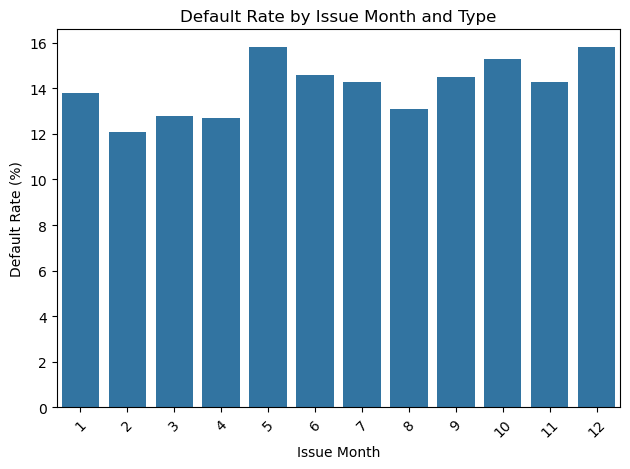

In [31]:
sns.barplot(
    data=monthly_summary,
    x='issue_month',
    y='default_rate_pct',
)

plt.title('Default Rate by Issue Month and Type')
plt.xlabel('Issue Month')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

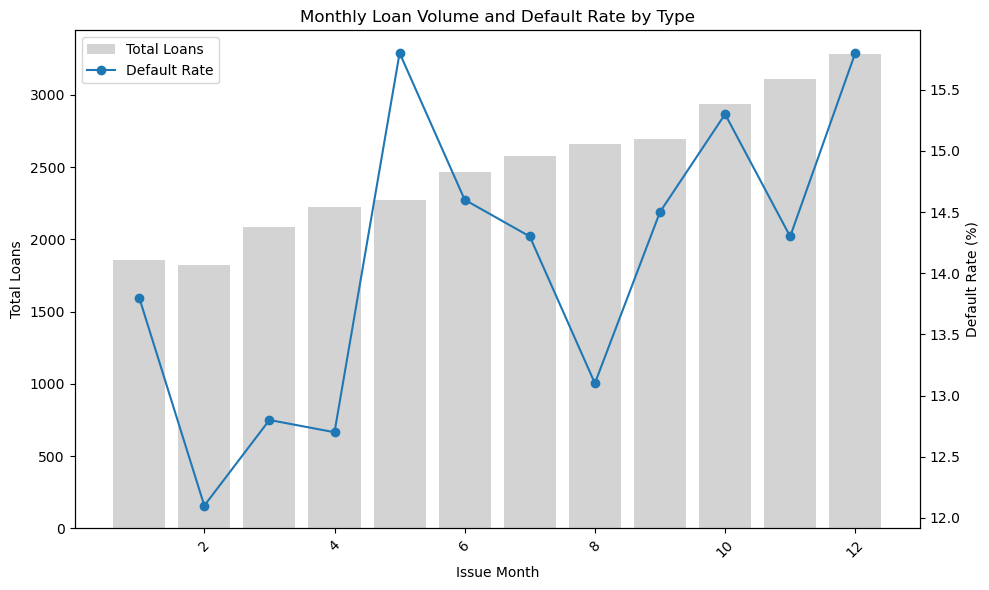

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 6))

total_loans_by_month = monthly_summary.groupby('issue_month')['total_loans'].sum()
ax1.bar(total_loans_by_month.index, total_loans_by_month.values, color='lightgray', label='Total Loans')

ax1.set_ylabel('Total Loans')
ax1.set_xlabel('Issue Month')
ax1.tick_params(axis='x', rotation=45)


ax2 = ax1.twinx()

ax2.plot(
    monthly_summary['issue_month'],
    monthly_summary['default_rate_pct'],
    marker='o',
    label=f'Default Rate'
)

ax2.set_ylabel('Default Rate (%)')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Monthly Loan Volume and Default Rate by Type')
fig.tight_layout()
plt.show()

# Distribution of Numerical Variables

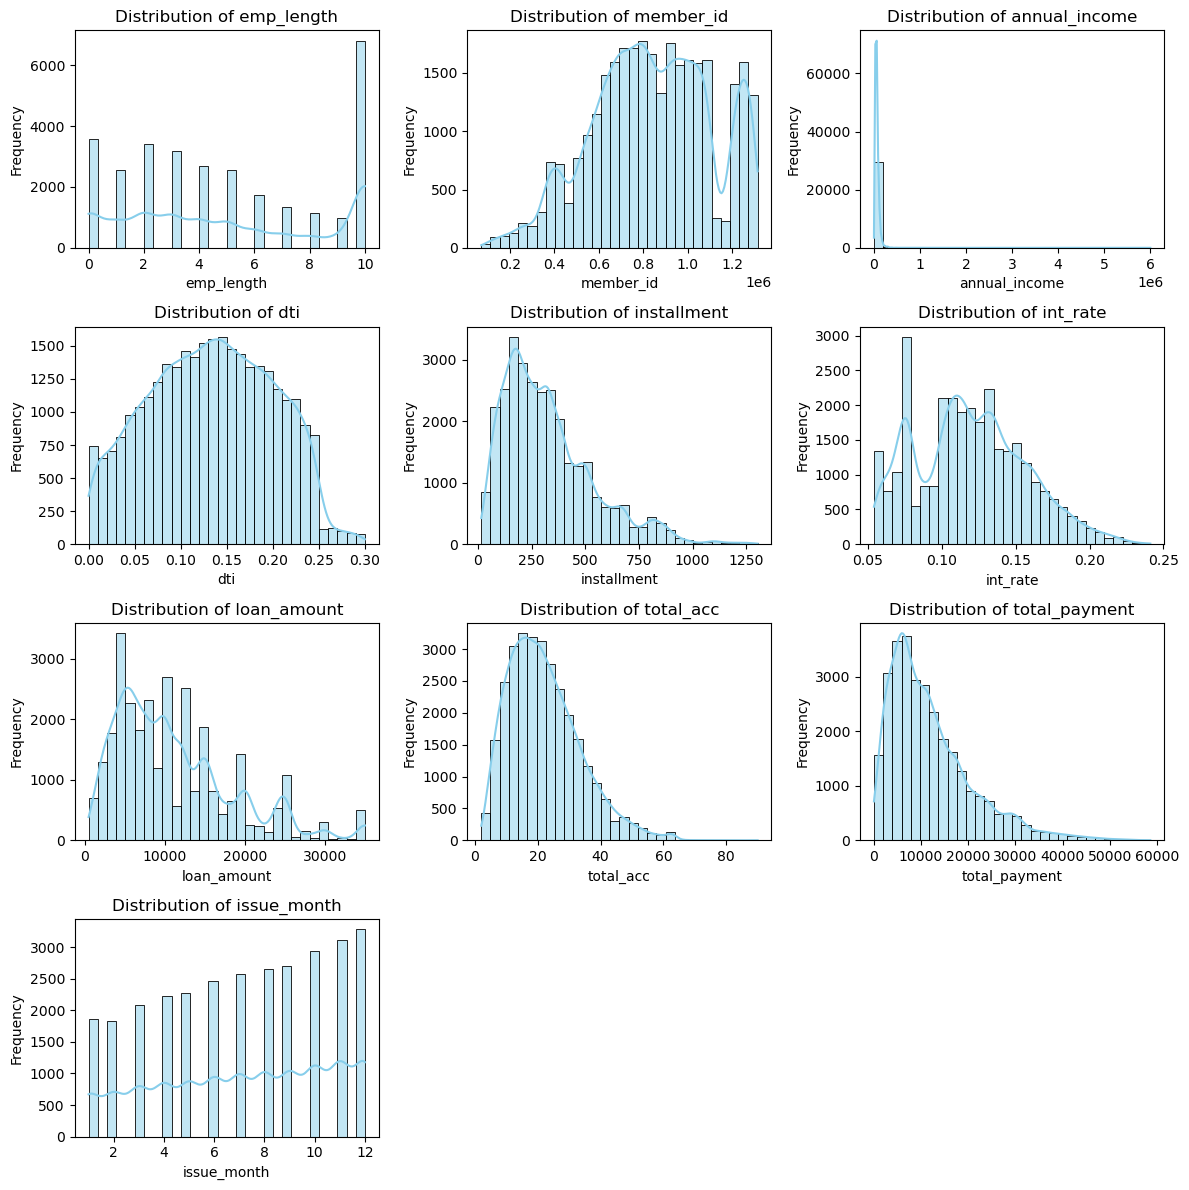

In [33]:
# REmoving 'defaulted' and `id` from the set of numerical features for visualization
num_cols = train_cp.drop(columns=['defaulted','id']).select_dtypes(include='number').columns

def plot_numerical_distributions(df, columns=None, bins=30, cols_per_row=3):
    """
    Plot histograms + KDEs for numerical columns using subplots (cols_per_row per row).
    """
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()

    total_plots = len(columns)
    n_cols = cols_per_row
    n_rows = math.ceil(total_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()  

    for i, col in enumerate(columns):
        sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[i],
                     color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Hide any extra unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_numerical_distributions(train_cp, columns=num_cols, cols_per_row=3)


## Outlier Detection

In this part, I use **boxplot** to determine if the distriubtions of the features are skewed or not. Based on the results, ``annual_income``, ``installment`` and ``total_acc`` are highly skewed. Therefore, I remove observations that exceed 99-percentile of these features. 

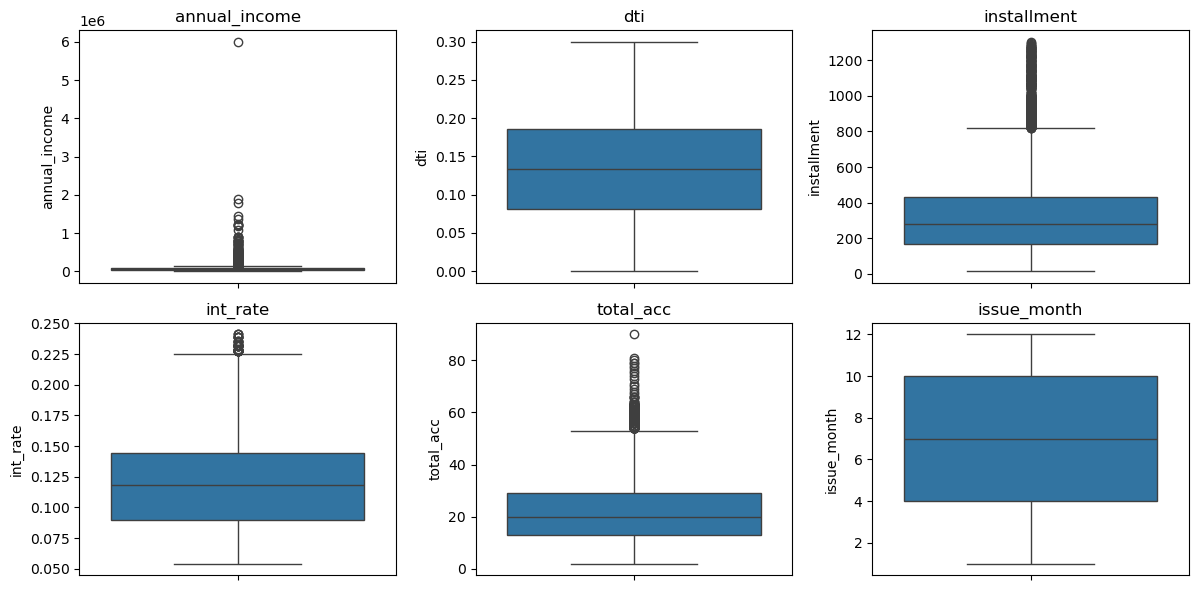

In [34]:
def plot_boxplots(df, num_features, exclude_columns=None, n_cols=3):

    # Remove excluded columns
    num_cols = [col for col in num_features if col not in (exclude_columns or [])]

    n_rows = int(np.ceil(len(num_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(col)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_boxplots(train_cp, num_features, exclude_columns=['defaulted'])


In [36]:
percentile = 0.99
thresholds  = {
    'annual_income': train_cp['annual_income'].quantile(percentile),
    'installment': train_cp['installment'].quantile(percentile),
    'total_acc': train_cp['total_acc'].quantile(percentile)
}
thresholds

{'annual_income': 234000.0,
 'installment': 926.5618999999987,
 'total_acc': 56.0}

In [37]:
def filter_by_fixed_thresholds(df, thresholds):

    df_filtered = df.copy()
    for feature, value in thresholds.items():
        if feature in df.columns:
            df_filtered = df_filtered[df_filtered[feature] <= value]
    return df_filtered

train = filter_by_fixed_thresholds(train, thresholds)
train_cp = filter_by_fixed_thresholds(train_cp, thresholds)
test = filter_by_fixed_thresholds(test, thresholds)

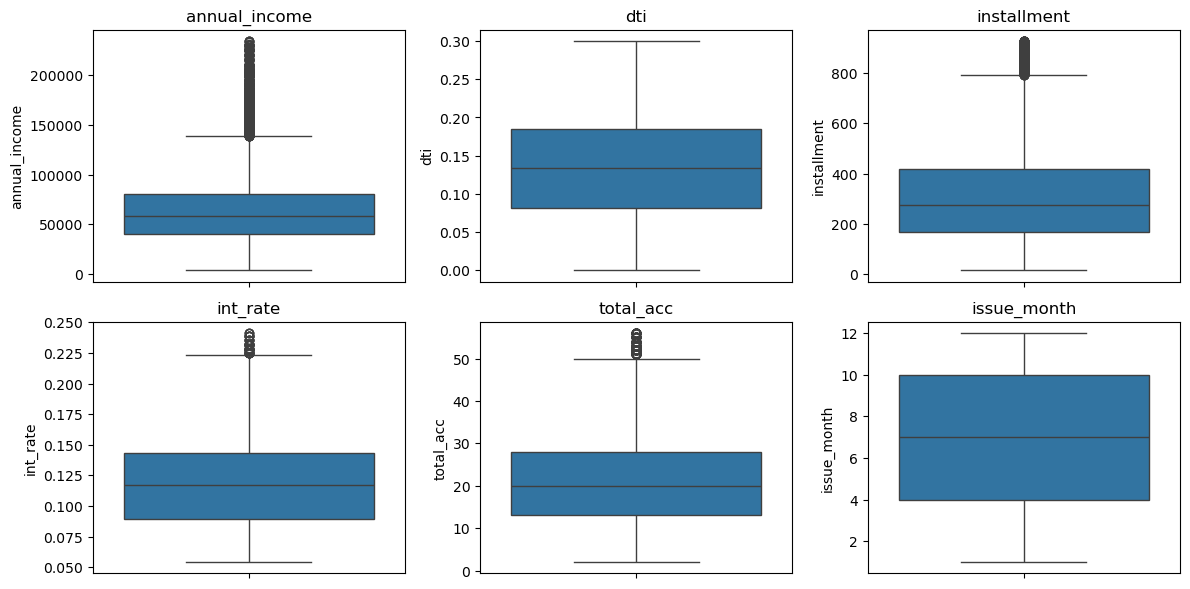

In [38]:
plot_boxplots(train_cp, num_features, exclude_columns=['defaulted'])

## Categorical

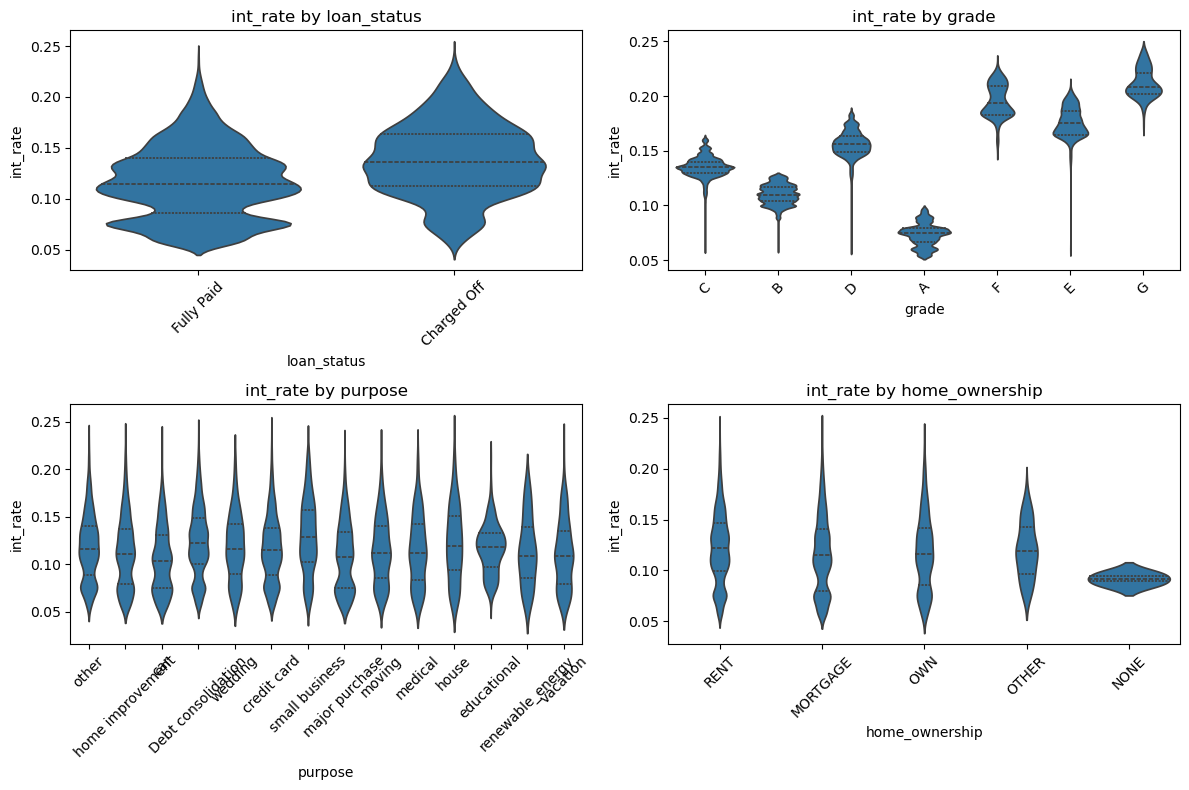

In [39]:
def plot_key_violin_plots(df):
    plots = [
        ('loan_status', 'int_rate'),
        ('grade', 'int_rate'),
        ('purpose', 'int_rate'),
        ('home_ownership', 'int_rate')
    ]

    n_plots = len(plots)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()  

    for i, (cat, num) in enumerate(plots):
        sns.violinplot(data=df, x=cat, y=num, inner='quartile', ax=axes[i])
        axes[i].set_title(f'{num} by {cat}')
        axes[i].set_xlabel(cat)
        axes[i].set_ylabel(num)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_key_violin_plots(train_cp)

In [40]:
def plot_default_rate(df, columns, length=8, width=4):

    num_cols = len(columns)
    fig, axs = plt.subplots(num_cols, 1, figsize=(length, width * num_cols), constrained_layout=True)

    if num_cols == 1:
        axs = [axs]

    for i, col in enumerate(columns):
        ax = axs[i]

        summary = df.groupby(col).agg(
            total=('defaulted', 'count'),
            defaulted=('defaulted', 'sum')
        ).reset_index()
        summary['default_rate'] = (summary['defaulted'] / summary['total']) * 100

        x = summary[col]
        total_counts = summary['total']
        default_counts = summary['defaulted']
        default_rate = summary['default_rate']

        ax.bar(x, total_counts, color='lightgray', label='Total')
        ax.bar(x, default_counts, color='red', label='Defaulted')

        for j in range(len(x)):
            ax.text(j, total_counts[j] + max(total_counts) * 0.01,
                    f"{default_rate[j]:.1f}%", ha='center', fontsize=10)

        ax.set_title(f'Default Rate by {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    plt.show()


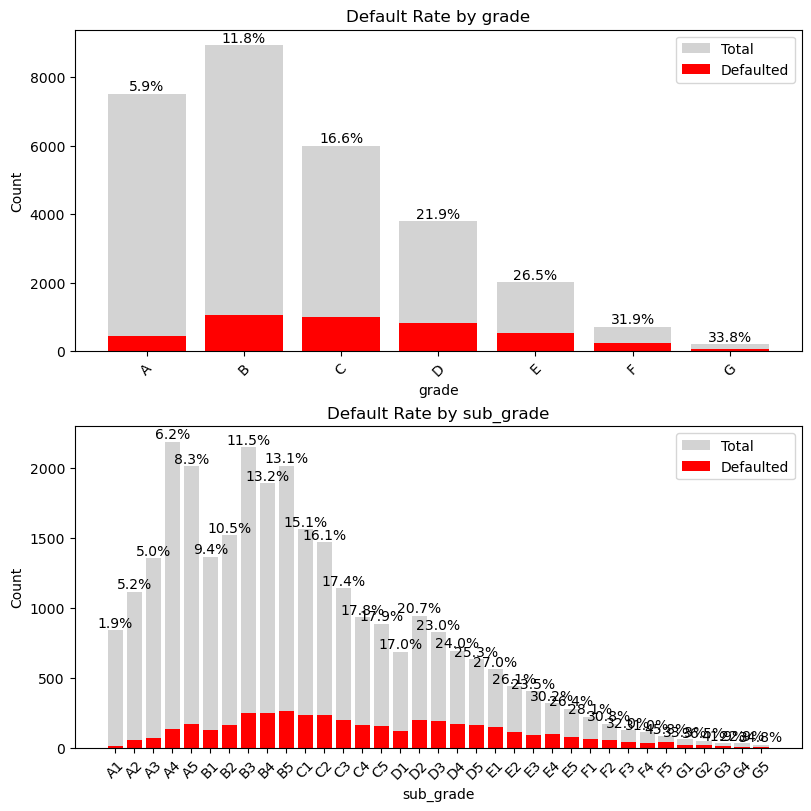

In [41]:
plot_default_rate(train_cp, ['grade', 'sub_grade'])

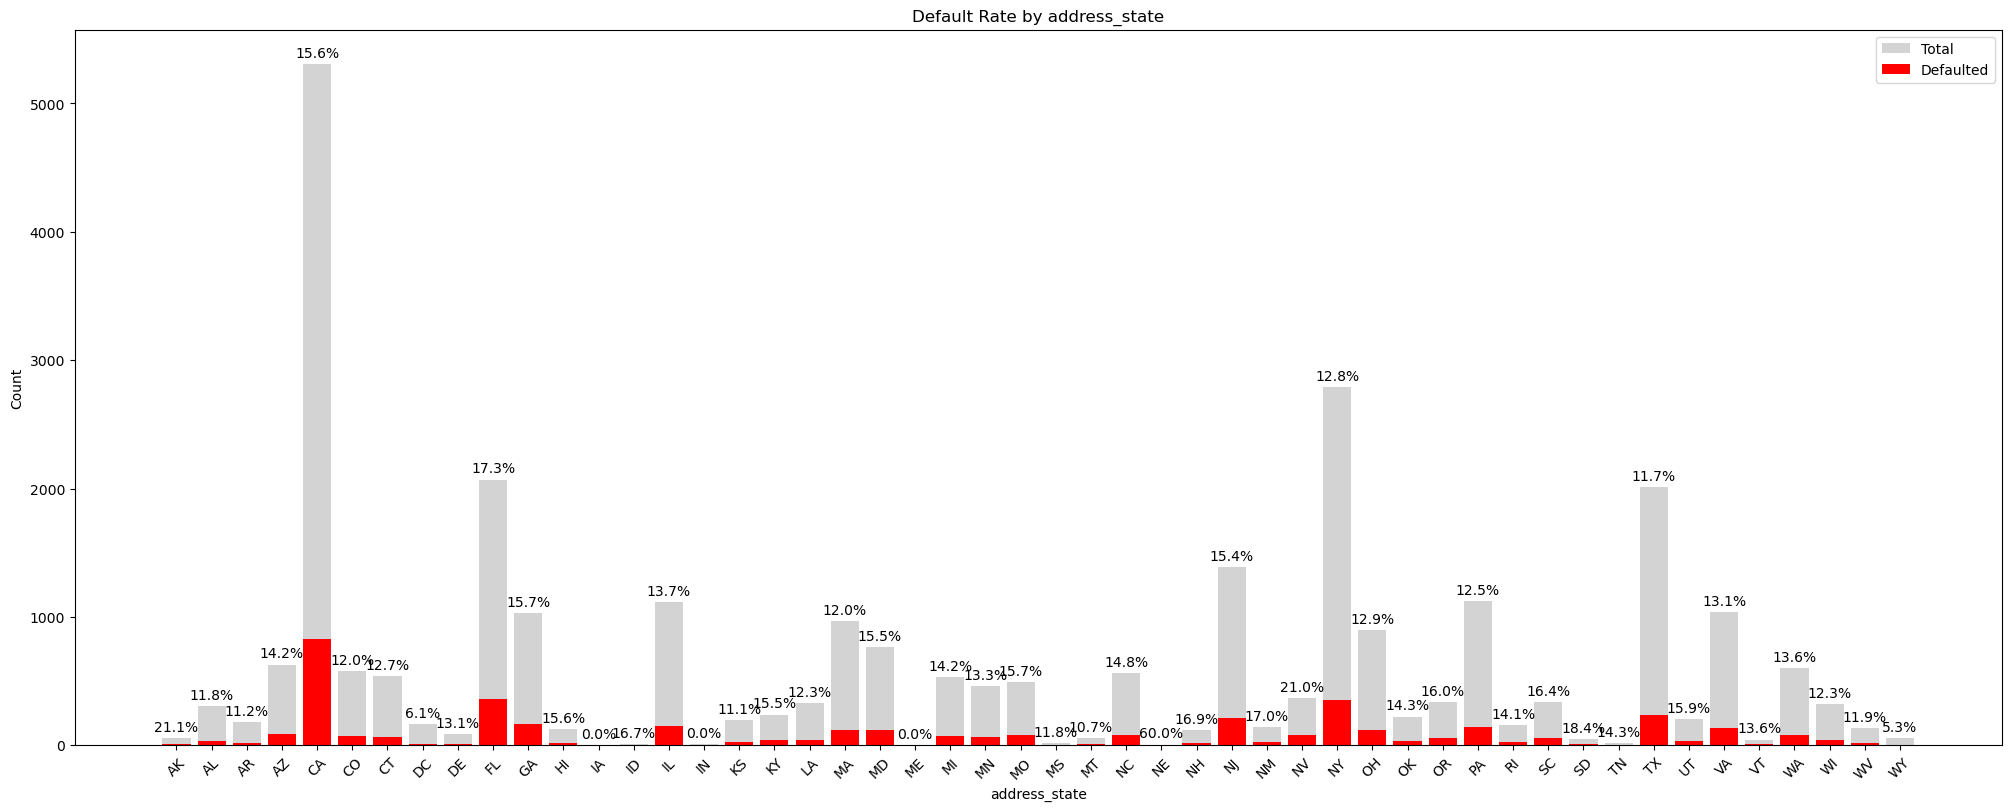

In [42]:
plot_default_rate(train_cp, ['address_state'], length =20, width=8)

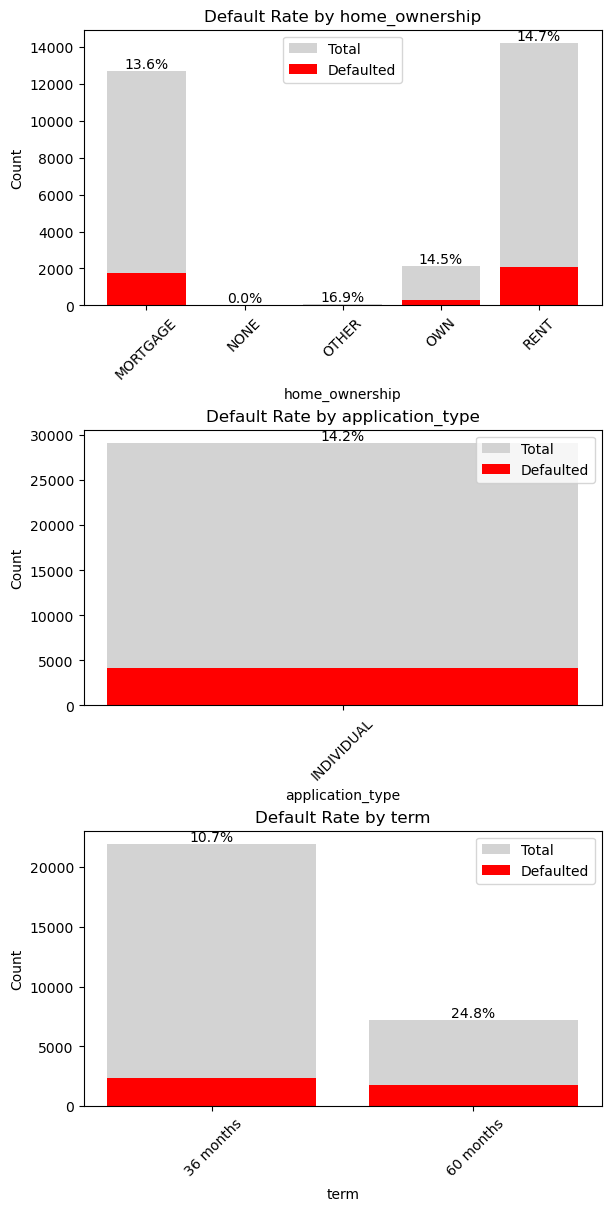

In [43]:
plot_default_rate(train_cp, ['home_ownership','application_type', 'term'], length =6)

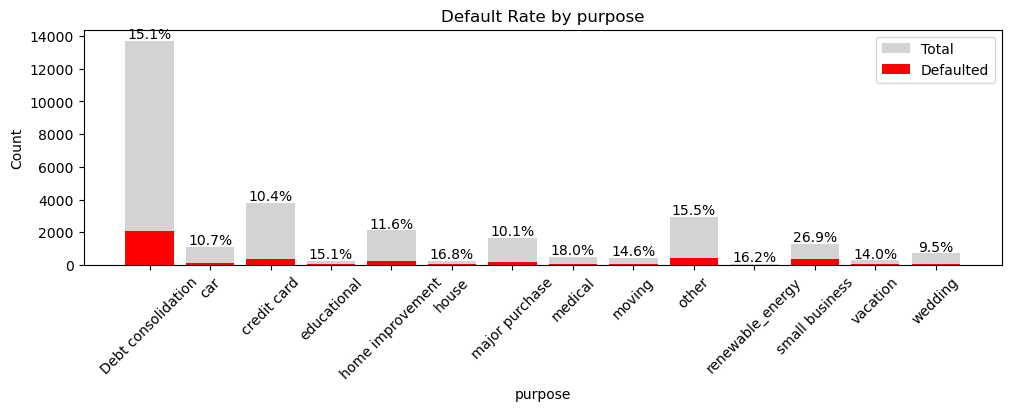

In [44]:
plot_default_rate(train_cp, ['purpose'], length =10)

# Feature Selection

Since most there are many features which are categorical and most libraries need one-hot encoded form of these features, I use ``LighGBM`` for feature selection where it automatically handle categorical features. 

In [246]:
cat_features

['address_state',
 'emp_length',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']

In [46]:
train_cp['defaulted']

21286    0
10188    0
33376    0
24800    0
25690    0
        ..
7116     0
33584    0
2402     0
35927    0
24098    0
Name: defaulted, Length: 29161, dtype: int32

In [47]:
import lightgbm as lgb

training_features = [col for col in pd_features if col not in ['defaulted', 'loan_status']]

# Prepare data
X = train_cp[training_features]
y = train_cp['defaulted']

# Convert object columns to category dtype for LightGBM
categorical_feature = [col for col in cat_features if col not in ['loan_status']]
for col in categorical_feature:
    X[col] = X[col].astype('category')

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store feature importances weighted by F1 score
feature_importances = pd.DataFrame(index=X.columns)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f'LightGBM fold {fold+1}/10 is running ....')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train, categorical_feature=categorical_feature)

    # F1 score
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    # Weight feature importances by F1 score
    perm_importance = permutation_importance(model, X_val, y_val, scoring='f1', random_state=42)
    feature_importances[f'fold_{fold+1}'] = perm_importance.importances_mean * f1

    

# Compute average importance
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='mean_importance', ascending=False)

LightGBM fold 1/10 is running ....
LightGBM fold 2/10 is running ....
LightGBM fold 3/10 is running ....
LightGBM fold 4/10 is running ....
LightGBM fold 5/10 is running ....
LightGBM fold 6/10 is running ....
LightGBM fold 7/10 is running ....
LightGBM fold 8/10 is running ....
LightGBM fold 9/10 is running ....
LightGBM fold 10/10 is running ....


In [48]:
feature_importances = feature_importances[feature_importances['mean_importance']>0]
feature_importance_df = (
    feature_importances[['mean_importance']]
    .sort_values(by='mean_importance', ascending=False)
    .assign(cum_importance=lambda df: df['mean_importance'].cumsum() / df['mean_importance'].sum())
    .reset_index()
    .rename(columns={'index': 'Feature', 'mean_importance': 'mean_importance'})
)

feature_importance_df

,Feature,mean_importance,cum_importance
0,int_rate,1.639692e-03,0.317937
1,term,1.392094e-03,0.587864
2,sub_grade,8.066473e-04,0.744273
3,purpose,7.172162e-04,0.883342
4,emp_length,2.293785e-04,0.927818
5,address_state,1.978038e-04,0.966172
6,grade,1.040934e-04,0.986356
7,issue_month,7.014466e-05,0.999957
8,total_acc,2.209462e-07,1.000000


In [49]:
pd_selected_features = feature_importance_df['Feature'].tolist()
pd_selected_features

['int_rate',
 'term',
 'sub_grade',
 'purpose',
 'emp_length',
 'address_state',
 'grade',
 'issue_month',
 'total_acc']

# WoE Results

In [50]:
def plot_woe(df, feature, target='defaulted', show_plots=True, ordered=False, length = 15):

    
    # Group and calculate counts
    grouped = df.groupby(feature)[target].agg(['count', 'sum']).rename(columns={'count': 'total', 'sum': 'bads'})
    grouped['goods'] = grouped['total'] - grouped['bads']
    
    total_goods = grouped['goods'].sum()
    total_bads = grouped['bads'].sum()

    # WoE and distribution
    epsilon = 1e-6
    grouped['dist_goods'] = grouped['goods'] / total_goods
    grouped['dist_bads'] = grouped['bads'] / total_bads
    grouped['woe'] = np.log((grouped['dist_goods'] + epsilon) / (grouped['dist_bads'] + epsilon))

    grouped['bad_pct'] = grouped['bads'] / grouped['total']
    grouped['good_pct'] = grouped['goods'] / grouped['total']
    grouped = grouped.reset_index()

    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(length, 5))

        # Order for WoE plot
        if ordered and pd.api.types.is_categorical_dtype(df[feature]):
            order = df[feature].cat.categories
            grouped_woe = grouped.set_index(feature).loc[order].reset_index()
        elif ordered:
            # Use natural sort order
            grouped_woe = grouped.sort_values(by=feature)
        else:
            # Sort by WoE
            grouped_woe = grouped.sort_values(by='woe')

        # WoE line plot
        axes[0].plot(grouped_woe[feature].astype(str), grouped_woe['woe'],
                     linestyle='--', marker='o', color='red', linewidth=2, markersize=8)
        axes[0].axhline(0, color='black', linewidth=0.8)
        axes[0].set_title(f'WoE by {feature}')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('WoE')
        axes[0].tick_params(axis='x', rotation=55)

        # Default rate bar chart
        grouped_bar = grouped.sort_values(by='bad_pct', ascending=False)
        labels = grouped_bar[feature].astype(str)
        axes[1].barh(labels, grouped_bar['bad_pct'], color='darkred', label='Bad')
        axes[1].barh(labels, grouped_bar['good_pct'], left=grouped_bar['bad_pct'], color='lightgray', label='Good')

        for i, (bad, good) in enumerate(zip(grouped_bar['bad_pct'], grouped_bar['good_pct'])):
            axes[1].text(bad / 2, i, f"{bad:.2%}", va='center', ha='center', color='white', fontsize=9)
            axes[1].text(bad + good / 2, i, f"{good:.2%}", va='center', ha='center', color='black', fontsize=9)

        axes[1].set_title(f'Default Rate by {feature}')
        axes[1].set_xlabel('Percentage')
        axes[1].legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    return grouped[[feature, 'total', 'goods', 'bads', 'woe', 'bad_pct', 'good_pct']]


In [51]:
# Compute WoE for a numerical variable using binning and optionally show:

def plot_woe_no(df, feature, target='defaulted', show_plots=True, ordered=True, n_bins=5, use_qcut=True):
    
    df_ = df.copy()

    # Bin the numeric feature, with either equal bin length or quantity
    if use_qcut:
        df_['bin'] = pd.qcut(df_[feature], q=n_bins, duplicates='drop')
    else:
        df_['bin'] = pd.cut(df_[feature], bins=n_bins)

    # Group by bin
    grouped = df_.groupby('bin')[target].agg(['count', 'sum']).rename(columns={'count': 'total', 'sum': 'bads'})
    grouped['goods'] = grouped['total'] - grouped['bads']

    total_goods = grouped['goods'].sum()
    total_bads = grouped['bads'].sum()

    # WoE and distribution
    epsilon = 1e-6
    grouped['dist_goods'] = grouped['goods'] / total_goods
    grouped['dist_bads'] = grouped['bads'] / total_bads
    grouped['woe'] = np.log((grouped['dist_goods'] + epsilon) / (grouped['dist_bads'] + epsilon))

    grouped['bad_pct'] = grouped['bads'] / grouped['total']
    grouped['good_pct'] = grouped['goods'] / grouped['total']
    grouped = grouped.reset_index()

    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))

        # Order bins
        if ordered:
            grouped_woe = grouped.sort_values(by='bin')
        else:
            grouped_woe = grouped.sort_values(by='woe')

        # WoE line plot
        axes[0].plot(grouped_woe['bin'].astype(str), grouped_woe['woe'],
                     linestyle='--', marker='o', color='red', linewidth=2, markersize=8)
        axes[0].axhline(0, color='black', linewidth=0.8)
        axes[0].set_title(f'WoE by {feature}')
        axes[0].set_xlabel('Bin')
        axes[0].set_ylabel('WoE')
        axes[0].tick_params(axis='x', rotation=55)

        # Default rate bar chart
        grouped_bar = grouped.sort_values(by='bad_pct', ascending=False)
        labels = grouped_bar['bin'].astype(str)
        axes[1].barh(labels, grouped_bar['bad_pct'], color='darkred', label='Bad')
        axes[1].barh(labels, grouped_bar['good_pct'], left=grouped_bar['bad_pct'], color='lightgray', label='Good')

        for i, (bad, good) in enumerate(zip(grouped_bar['bad_pct'], grouped_bar['good_pct'])):
            axes[1].text(bad / 2, i, f"{bad:.2%}", va='center', ha='center', color='white', fontsize=9)
            axes[1].text(bad + good / 2, i, f"{good:.2%}", va='center', ha='center', color='black', fontsize=9)

        axes[1].set_title(f'Default Rate by {feature}')
        axes[1].set_xlabel('Percentage')
        axes[1].legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    return grouped[['bin', 'total', 'goods', 'bads', 'woe', 'bad_pct', 'good_pct']]


## Categorical Variables

## issue_month

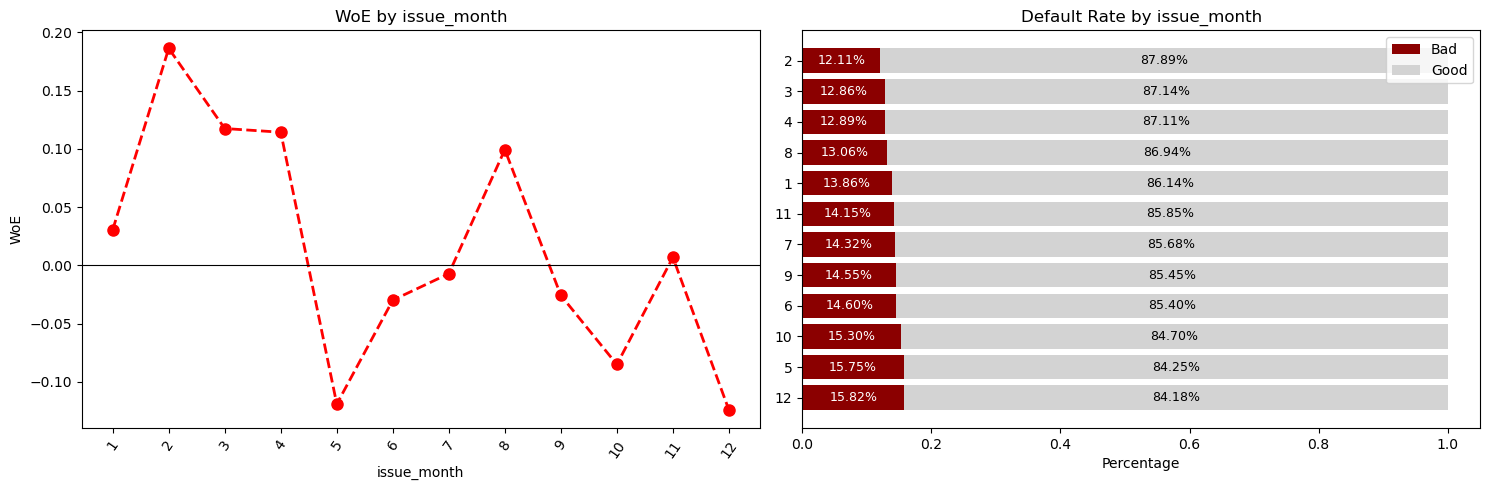

In [52]:
_ = plot_woe(train_cp, 'issue_month', show_plots=True, ordered=True)

In [53]:
def merge_issue_month(m):
    if m in [5, 10, 12]:
        return 'High_Risk'
    elif m in [1, 6, 7, 9, 11]:
        return 'Moderate_Risk'
    elif m in [2, 3, 4, 8]:
        return 'Low_Risk'
        
train_cp['issue_month2'] = train_cp['issue_month'].apply(merge_issue_month)

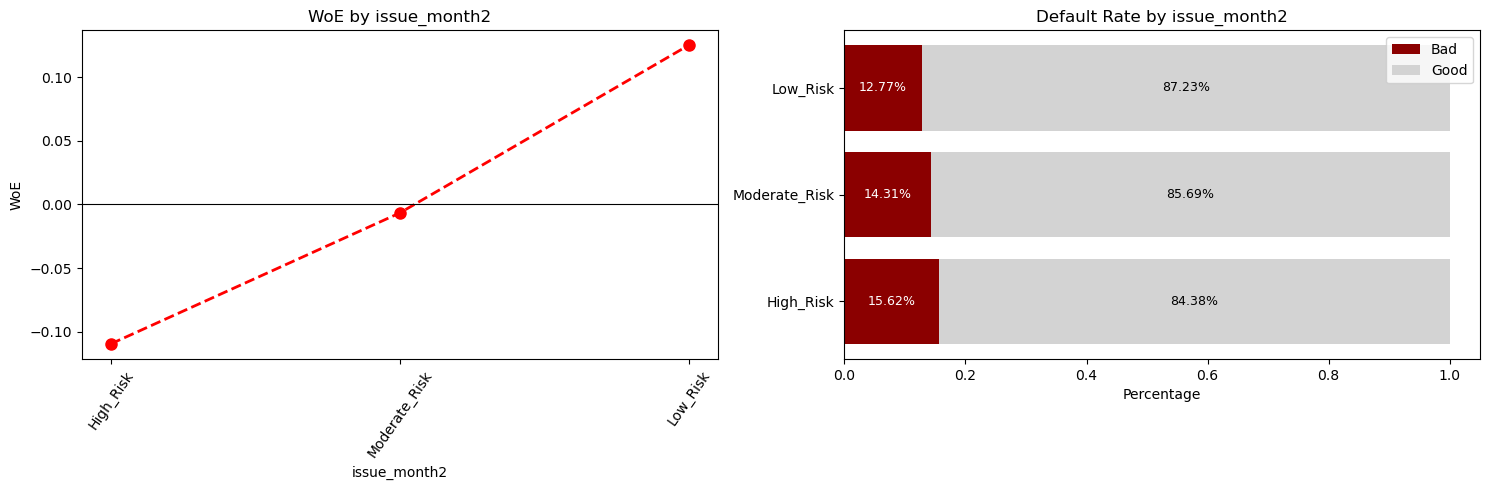

In [54]:
_ = plot_woe(train_cp, 'issue_month2', show_plots=True, ordered=False)

## term

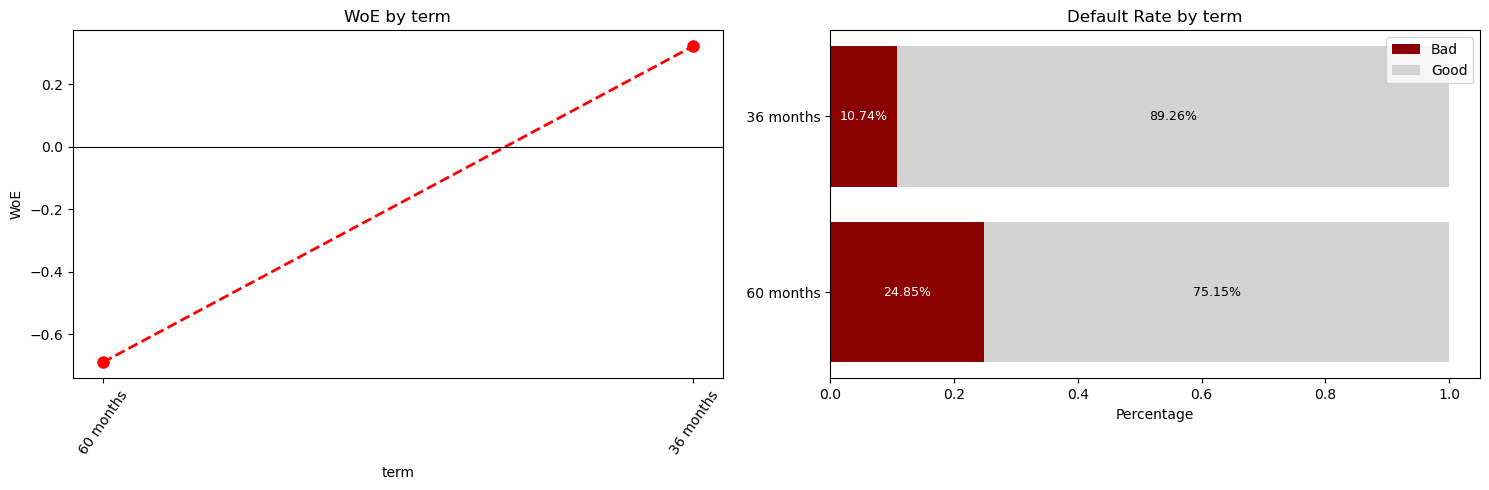

In [55]:
_ = plot_woe(train_cp, 'term', show_plots=True)

## Sub_grade

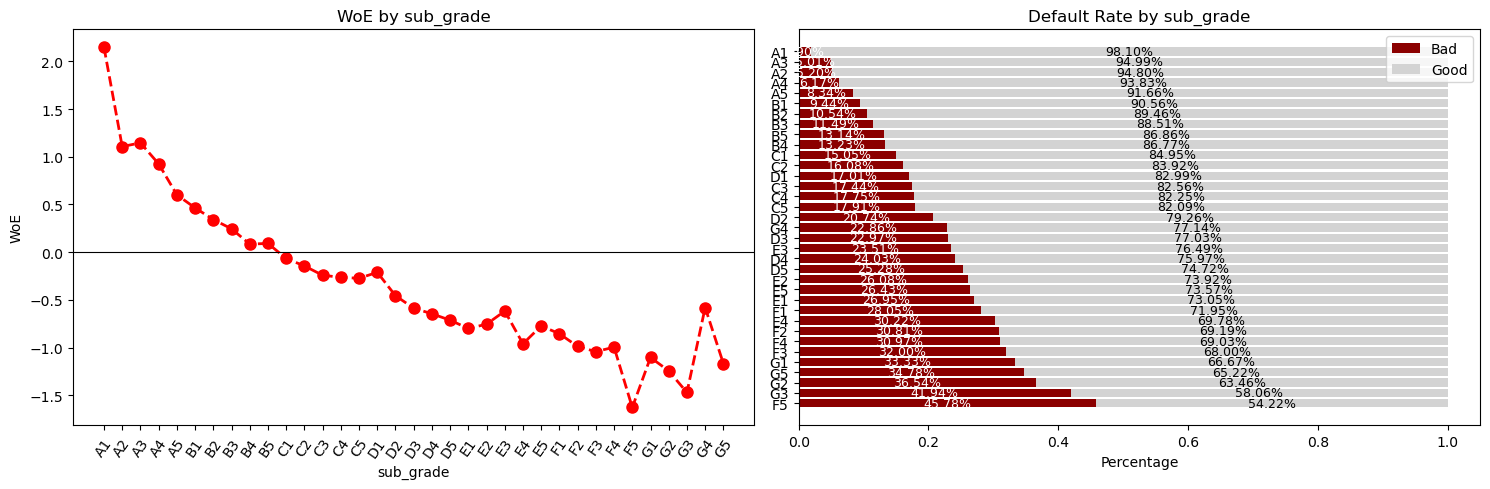

In [56]:
a = plot_woe(train_cp, 'sub_grade', show_plots=True, ordered=True)

In [57]:
def merge_sub_grade(s):
    if s == 'A1':
        return 'Ultra_Low_Risk'
    elif s in ['A2', 'A3', 'A4']:
        return 'Very_Low_Risk'
    elif s in ['A5', 'B1', 'B2', 'B3']:
        return 'Low_Risk'
    elif s in ['B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1']:
        return 'Medium_Low_Risk'
    elif s in ['D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3']:
        return 'Medium_Risk'
    elif s in ['E4', 'E5', 'F1', 'F2', 'F3', 'F4']:
        return 'High_Risk'
    else:  # F5 to G5
        return 'Very_High_Risk'


train_cp['sub_grade2'] = train_cp['sub_grade'].apply(merge_sub_grade)

print(train_cp['sub_grade2'].value_counts())

sub_grade2
Medium_Low_Risk    10587
Low_Risk            7048
Very_Low_Risk       4660
Medium_Risk         4509
High_Risk           1232
Ultra_Low_Risk       841
Very_High_Risk       284
Name: count, dtype: int64


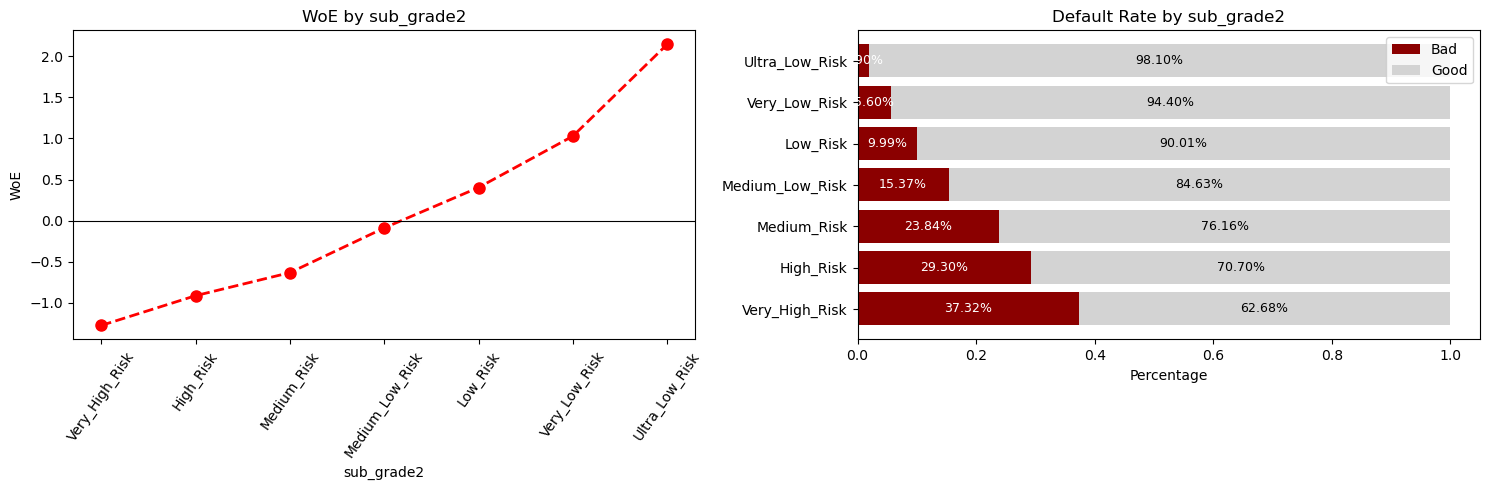

In [58]:
_ = plot_woe(train_cp, 'sub_grade2', show_plots=True)

## Purpose

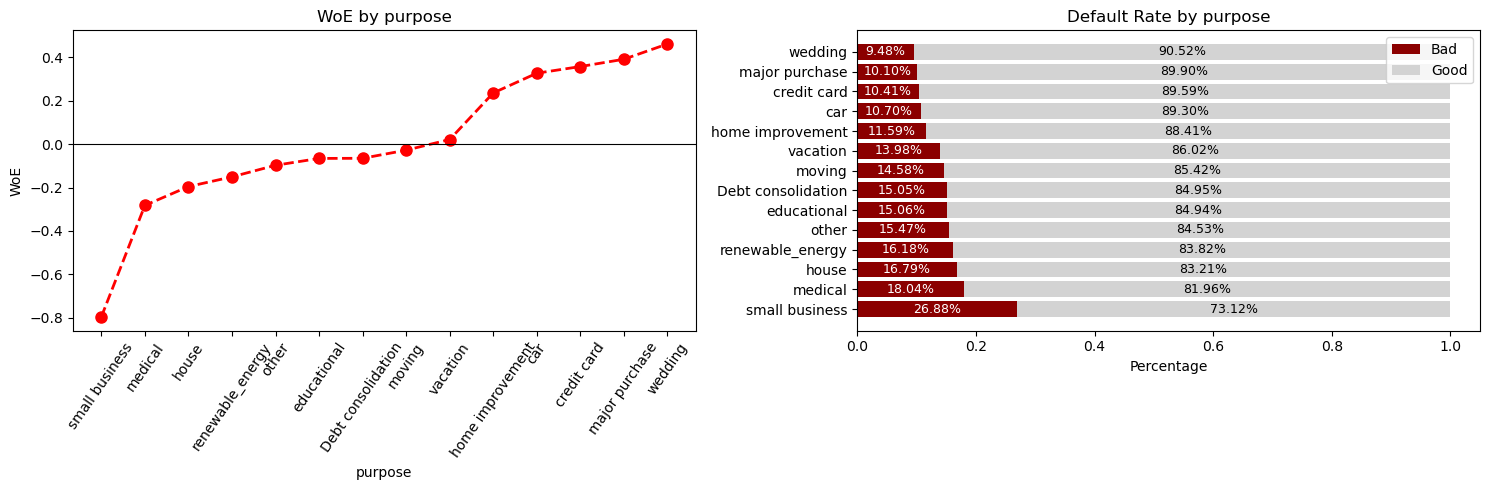

In [59]:
a = plot_woe(train_cp, 'purpose', show_plots=True)

In [60]:
def merge_purpose(s):
    if s in ['home improvement', 'car', 'credit card', 'major purchase', 'wedding']:
        return 'Low_Risk'
    elif s in ['other', 'educational', 'Debt consolidation', 'moving', 'vacation']:
        return 'Medium_Risk'
    elif s in ['medical', 'house', 'renewable_energy']:
        return 'High_Risk'
    else: 
        return 'Very_High_Risk'


train_cp['purpose2'] = train_cp['purpose'].apply(merge_purpose)

print(train_cp['purpose2'].value_counts())


purpose2
Medium_Risk       17613
Low_Risk           9411
Very_High_Risk     1302
High_Risk           835
Name: count, dtype: int64


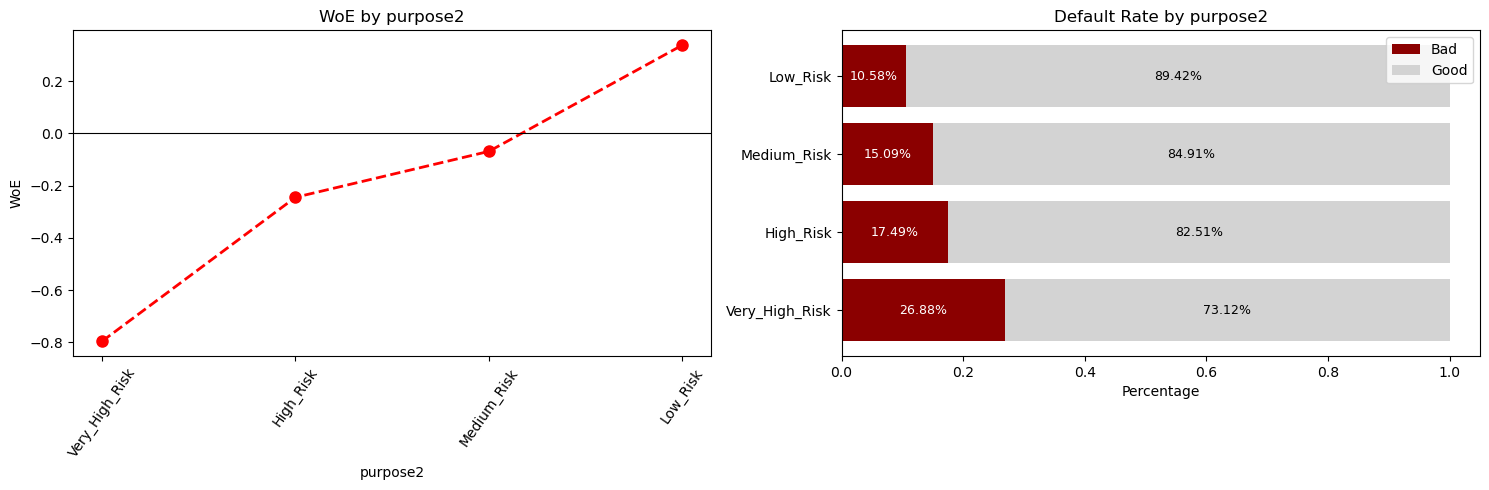

In [61]:
_ = plot_woe(train_cp, 'purpose2', show_plots=True)

## Grade

Based on the following graph, it is better to merge levels ``F`` and ``G``.

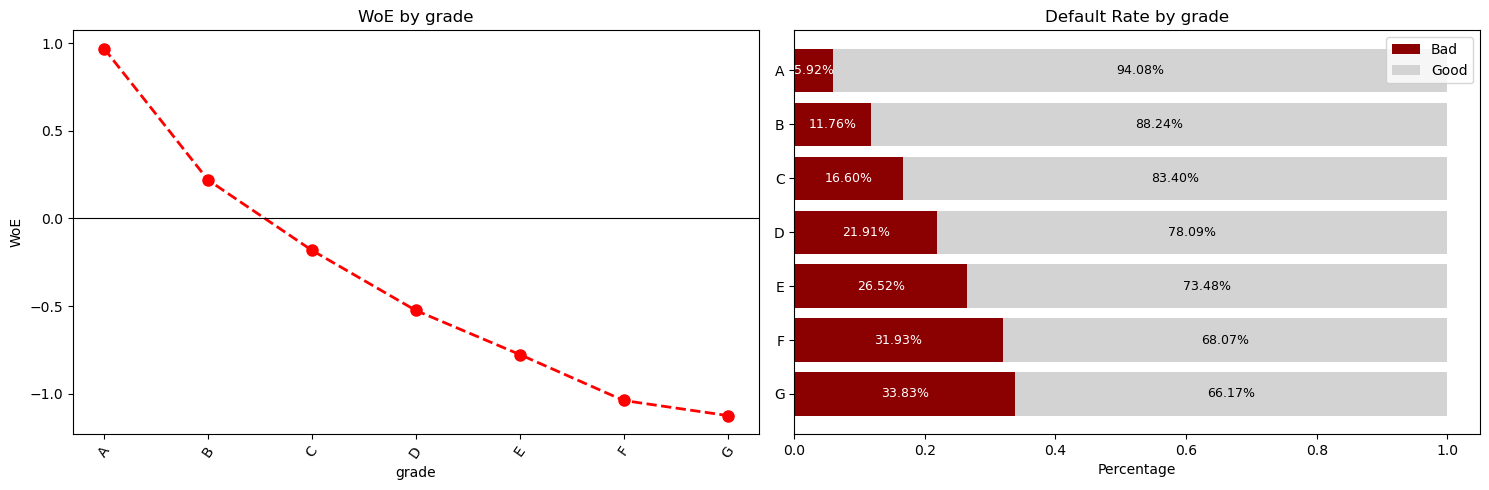

In [62]:
_ = plot_woe(train_cp, 'grade', show_plots=True, ordered=True)

In [63]:
grade_mapping = {
    'G': 'F/G',
    'F': 'F/G'
}
train_cp['grade2'] = train_cp['grade'].replace(grade_mapping)

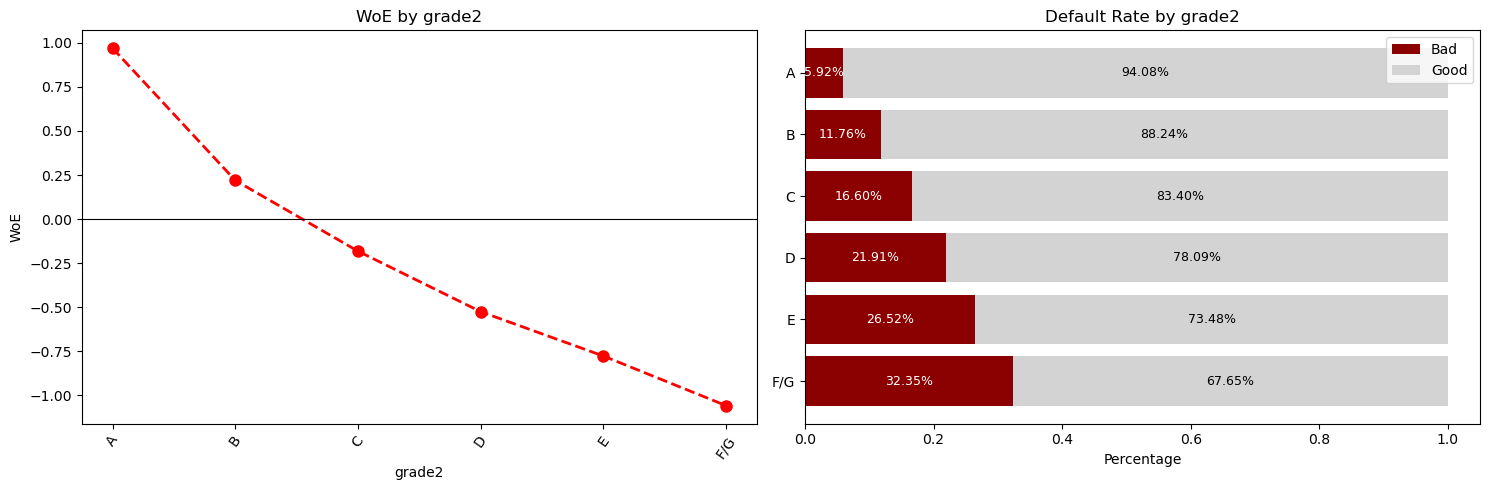

In [64]:
_ = plot_woe(train_cp, 'grade2', show_plots=True, ordered=True)

## Employement Length

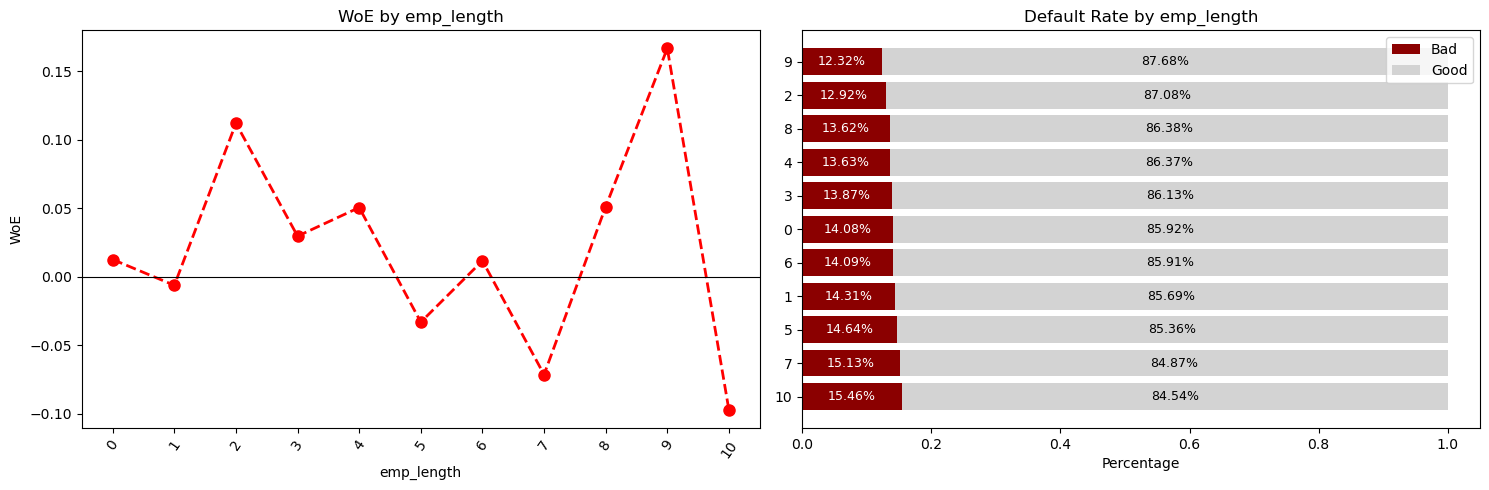

In [65]:
_ = plot_woe(train_cp, 'emp_length', show_plots=True, ordered=True)

In [66]:
def merge_emp_length(s):
    if s in [0, 1]:
        return '00-01 years'
    elif s in [2, 3, 4]:
        return '02-04 years'
    elif s in [5, 6, 7]:
        return '05-07 years'
    elif s in [8, 9]:
        return '08-09 years'
    else:  # 10+
        return '10+ years'

train_cp['emp_length2'] = train_cp['emp_length'].apply(merge_emp_length)

print(train_cp['emp_length2'].value_counts())

emp_length2
02-04 years    9107
10+ years      6494
00-01 years    6032
05-07 years    5484
08-09 years    2044
Name: count, dtype: int64


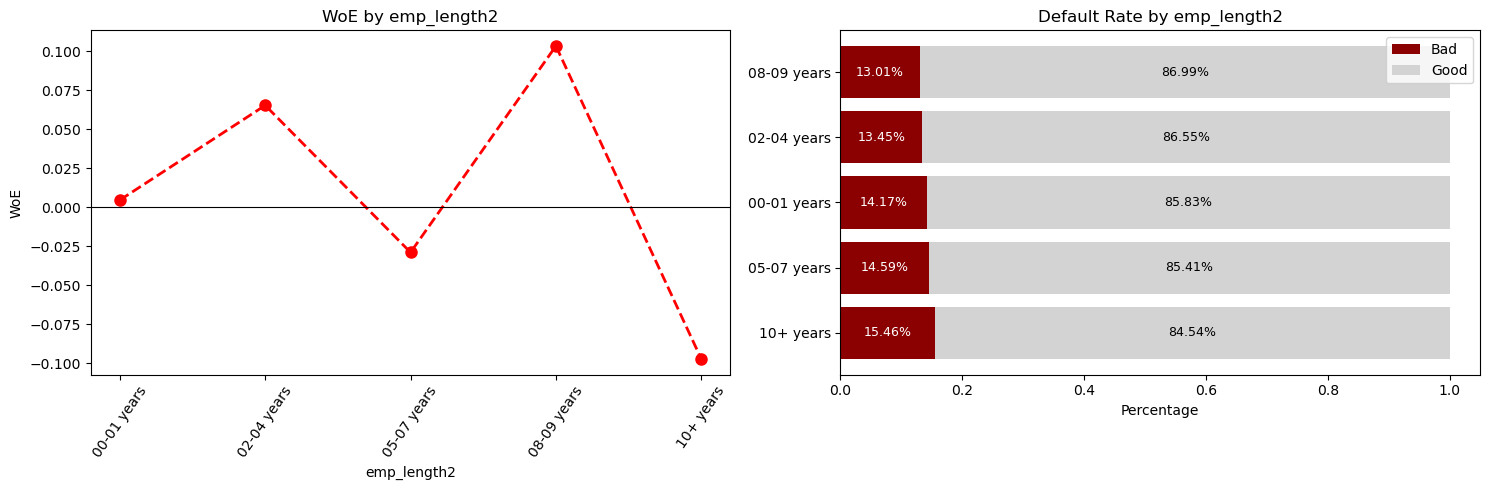

In [67]:
_ = plot_woe(train_cp, 'emp_length2', show_plots=True, ordered=True)

## Address

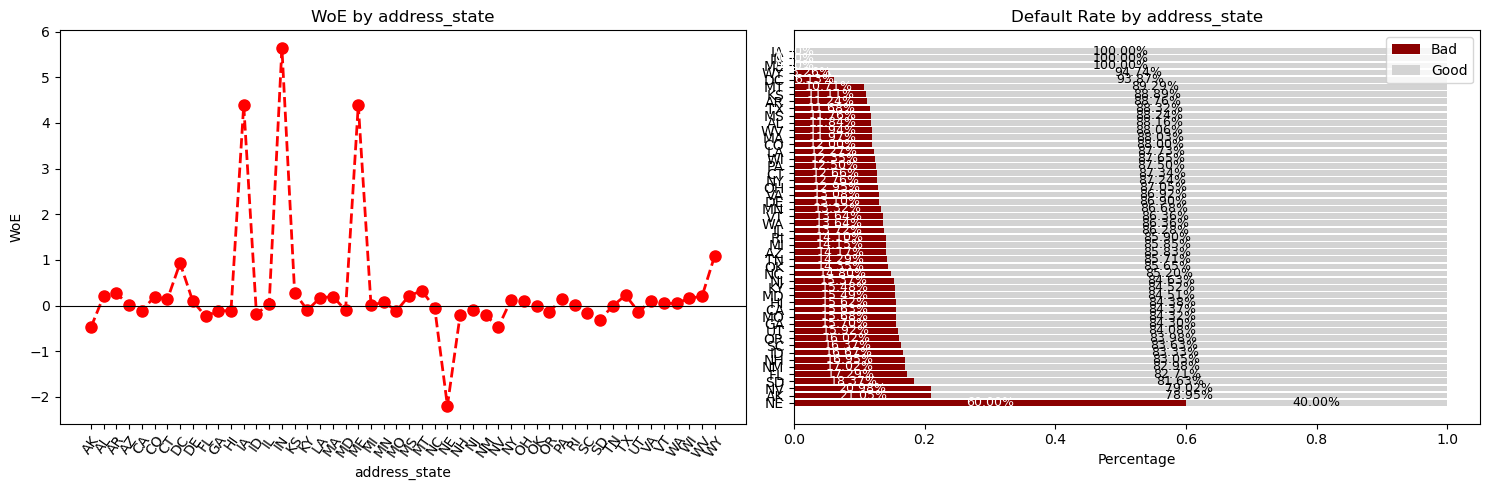

In [68]:
a = plot_woe(train_cp, 'address_state', show_plots=True, ordered=True)

In [70]:
def merge_address(s):
    if s in ['IN', 'ME', 'IA', 'WY', 'DC']:
        return 'Low_Risk'
    elif s in ['NE', 'AK', 'NV']:
        return 'High_Risk'
    else: 
        return 'Medium_Risk'

train_cp['address_state2'] = train_cp['address_state'].apply(merge_address)

print(train_cp['address_state2'].value_counts())


address_state2
Medium_Risk    28501
High_Risk        429
Low_Risk         231
Name: count, dtype: int64


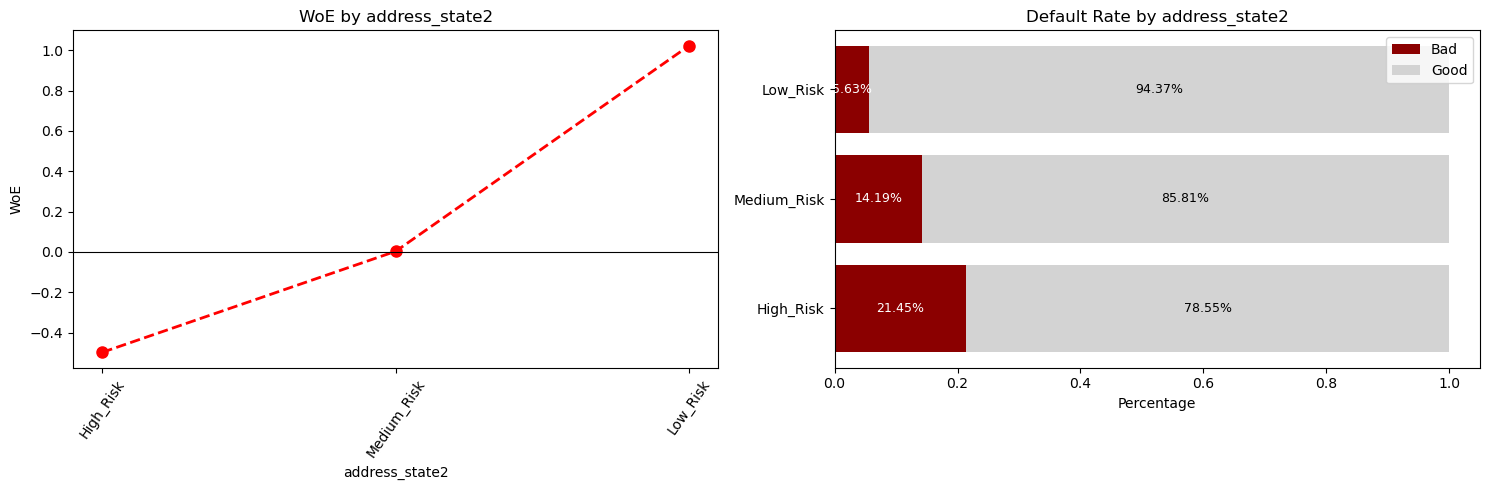

In [71]:
_ = plot_woe(train_cp, 'address_state2', show_plots=True, ordered=False)

# Discretizing Numerical Variables

## Interest_rate

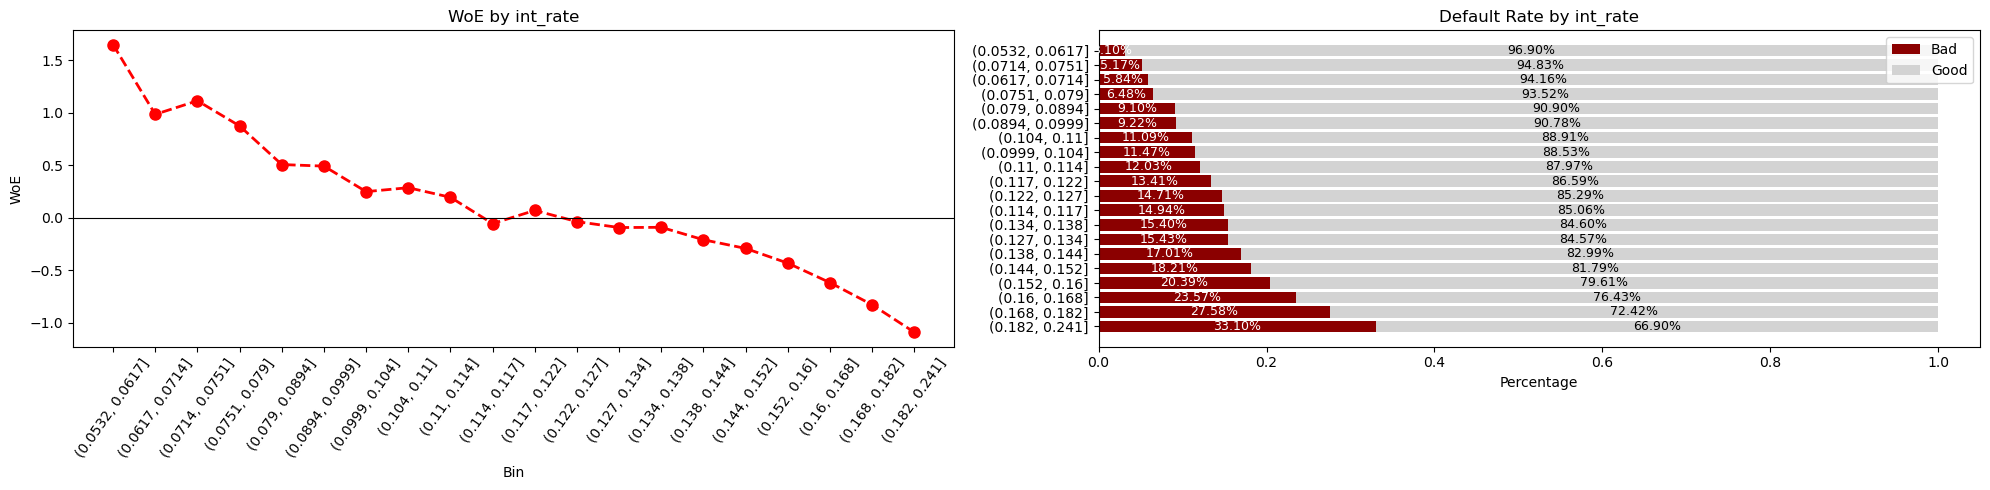

In [72]:
_ = plot_woe_no(train_cp, 'int_rate', target='defaulted', show_plots=True, ordered=True, n_bins=20, use_qcut=True)

In [73]:
def merge_int_rate(r):
    if r <= 0.07:
        return 'Very_Low_Risk'
    elif r <= 0.10:
        return 'Low_Risk'
    elif r <= 0.13:
        return 'Medium_Risk'
    elif r <= 0.16:
        return 'High_Risk'
    else:
        return 'Very_High_Risk'

train_cp['int_rate2'] = train_cp['int_rate'].apply(merge_int_rate)


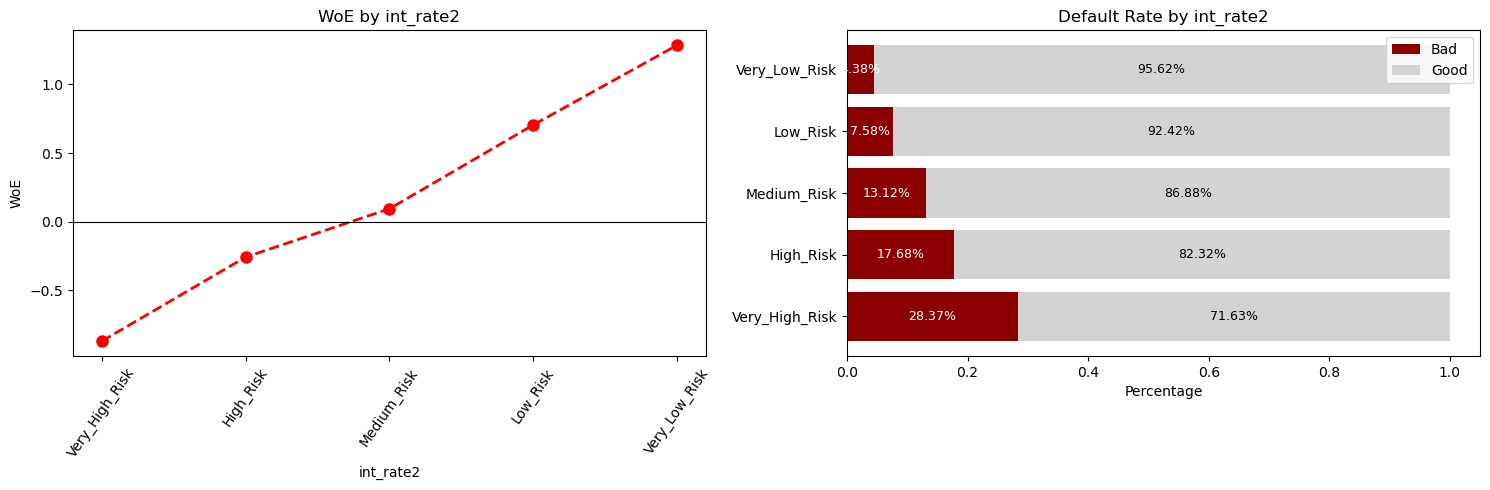

In [74]:
_ = plot_woe(train_cp, 'int_rate2', target='defaulted', show_plots=True)

## Total_acc

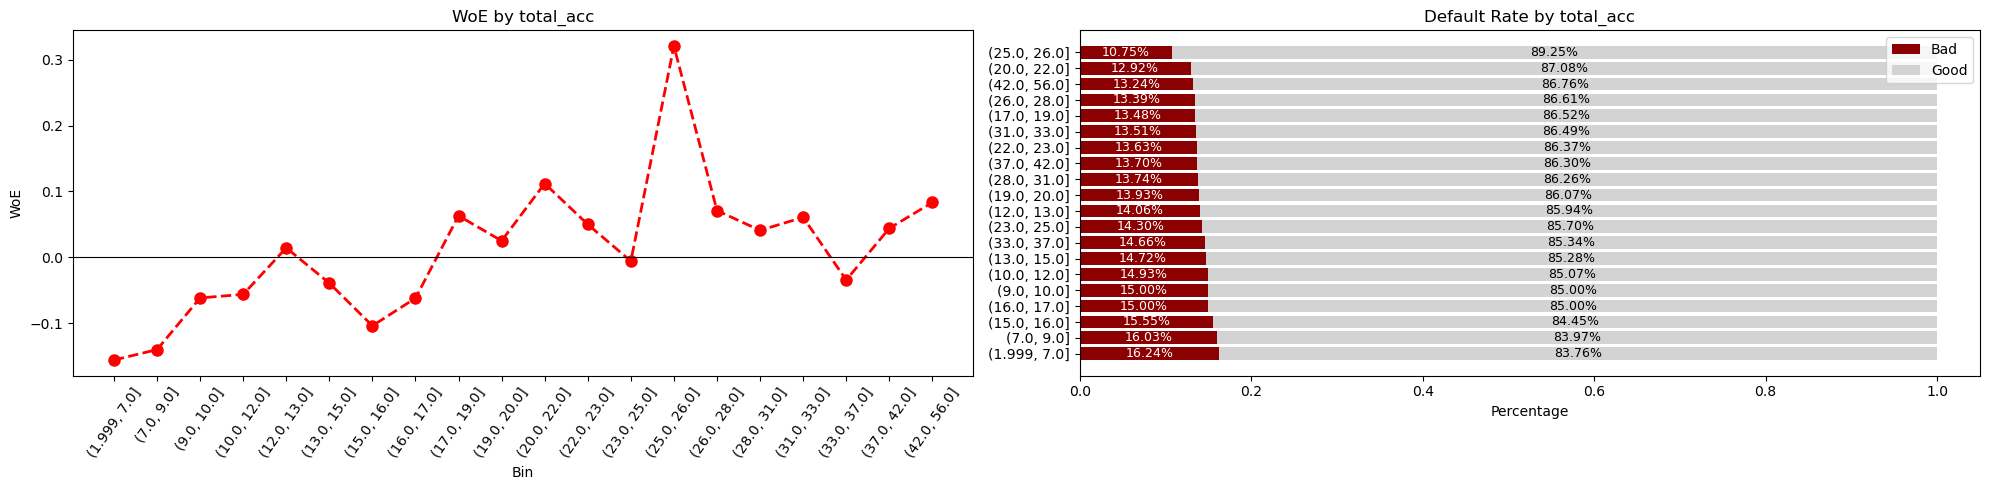

In [75]:
_ = plot_woe_no(train_cp, 'total_acc', target='defaulted', show_plots=True, ordered=True, n_bins=20, use_qcut=True)

In [76]:
def merge_total_acc(x):
    if x <= 17:
        return 'Low_Risk'
    else:
        return 'High_Risk'

train_cp['total_acc2'] = train_cp['total_acc'].apply(merge_total_acc)

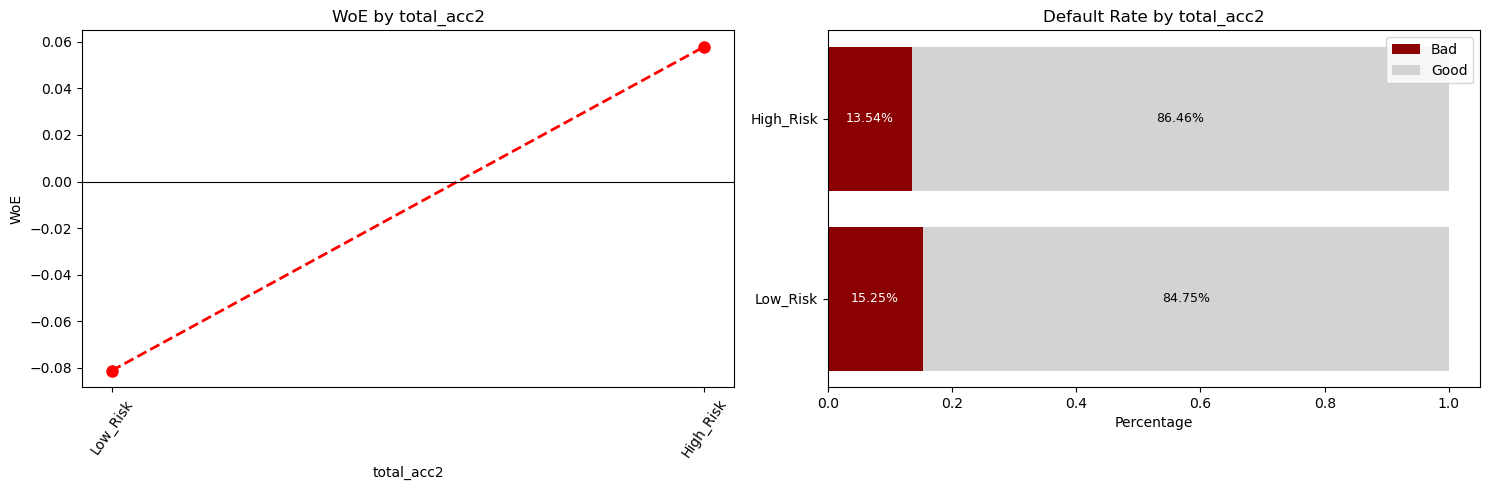

In [77]:
_ = plot_woe(train_cp, 'total_acc2', target='defaulted', show_plots=True)

# Converting All Features

In [78]:
def convert_to_levels(df):
    df = df.copy()

    # issue_month
    def merge_issue_month(m):
        if m in [5, 10, 12]:
            return 'High_Risk'
        elif m in [1, 6, 7, 9, 11]:
            return 'Moderate_Risk'
        elif m in [2, 3, 4, 8]:
            return 'Low_Risk'

    df['issue_month'] = df['issue_month'].apply(merge_issue_month)

    # sub_grade
    def merge_sub_grade(s):
        if s == 'A1':
            return 'Ultra_Low_Risk'
        elif s in ['A2', 'A3', 'A4']:
            return 'Very_Low_Risk'
        elif s in ['A5', 'B1', 'B2', 'B3']:
            return 'Low_Risk'
        elif s in ['B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1']:
            return 'Medium_Low_Risk'
        elif s in ['D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3']:
            return 'Medium_Risk'
        elif s in ['E4', 'E5', 'F1', 'F2', 'F3', 'F4']:
            return 'High_Risk'
        else:
            return 'Very_High_Risk'

    df['sub_grade'] = df['sub_grade'].apply(merge_sub_grade)

    # purpose
    def merge_purpose(s):
        if s in ['home improvement', 'car', 'credit card', 'major purchase', 'wedding']:
            return 'Low_Risk'
        elif s in ['other', 'educational', 'Debt consolidation', 'moving', 'vacation']:
            return 'Medium_Risk'
        elif s in ['medical', 'house', 'renewable_energy']:
            return 'High_Risk'
        else:
            return 'Very_High_Risk'

    df['purpose'] = df['purpose'].apply(merge_purpose)

    # grade: group F and G
    grade_mapping = {
        'F': 'F/G',
        'G': 'F/G'
    }
    df['grade'] = df['grade'].replace(grade_mapping)

    # emp_length
    def merge_emp_length(s):
        if s in [0, 1]:
            return '00-01 years'
        elif s in [2, 3, 4]:
            return '02-04 years'
        elif s in [5, 6, 7]:
            return '05-07 years'
        elif s in [8, 9]:
            return '08-09 years'
        else:
            return '10+ years'

    df['emp_length'] = df['emp_length'].apply(merge_emp_length)

    # address_state
    def merge_address(s):
        if s in ['IN', 'ME', 'IA']:
            return 'Low_Risk'
        elif s in ['WY', 'DC']:
            return 'Low_Risk'
        elif s in ['NE', 'AK', 'NV']:
            return 'High_Risk'
        else:
            return 'Medium_Risk'

    df['address_state'] = df['address_state'].apply(merge_address)

    # int_rate
    def merge_int_rate(r):
        if r <= 0.07:
            return 'Very_Low_Risk'
        elif r <= 0.10:
            return 'Low_Risk'
        elif r <= 0.13:
            return 'Medium_Risk'
        elif r <= 0.16:
            return 'High_Risk'
        else:
            return 'Very_High_Risk'

    df['int_rate'] = df['int_rate'].apply(merge_int_rate)

    # total_acc
    def merge_total_acc(x):
        if x <= 17:
            return 'Low_Risk'
        else:
            return 'High_Risk'

    df['total_acc'] = df['total_acc'].apply(merge_total_acc)

    return df


In [79]:
train_cp = convert_to_levels(train_cp)
test = convert_to_levels(test)

In [80]:
train_cp['address_state'].value_counts()

address_state
Medium_Risk    28501
High_Risk        429
Low_Risk         231
Name: count, dtype: int64

# PD Prediction Using Logistic Regression

In the dataset, since calsses are not balanced, I use undersampling to balance the dataset. 

I first ran the code and found that because of existence of both ``grade`` and ``sub_grade``, the model does not converge. Therefore, I remove ``grade``.

In [98]:
# Drop 'grade'
safe_features = [col for col in pd_selected_features if col != 'grade']

# Define formula
formula = 'defaulted ~ ' + ' + '.join([f'C({col})' for col in safe_features])

# Split the training data into X and y for oversampling
X = train_cp[safe_features]
y = train_cp['defaulted']

# Perform random undersampling
ros = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Recombine into one DataFrame
resampled_df = X_resampled.copy()
resampled_df['defaulted'] = y_resampled

# Fit logistic regression model on undersampled data
model = smf.logit(formula=formula, data=resampled_df).fit(maxiter=1000)
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.632137
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              defaulted   No. Observations:                 8300
Model:                          Logit   Df Residuals:                     8276
Method:                           MLE   Df Model:                           23
Date:                Fri, 23 May 2025   Pseudo R-squ.:                 0.08802
Time:                        01:05:46   Log-Likelihood:                -5246.7
converged:                       True   LL-Null:                       -5753.1
Covariance Type:            nonrobust   LLR p-value:                2.565e-199
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.5658      0.280      5.595  

In [104]:
y_proba = model.predict(train_cp)

y_pred = (y_proba >= 0.524).astype(int)

y_true = train_cp['defaulted']


In [105]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("AUC Score:", roc_auc_score(y_true, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Accuracy: 0.6828983916875279
Precision: 0.24296520423600604
Recall: 0.5804819277108434
F1 Score: 0.3425524351226449
AUC Score: 0.6918490177574879
Confusion Matrix:
 [[17505  7506]
 [ 1741  2409]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79     25011
           1       0.24      0.58      0.34      4150

    accuracy                           0.68     29161
   macro avg       0.58      0.64      0.57     29161
weighted avg       0.81      0.68      0.73     29161



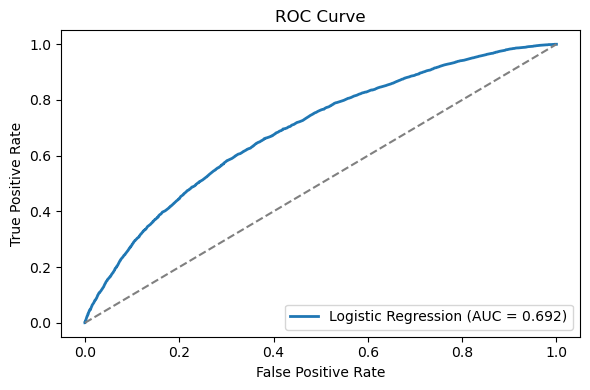

In [106]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
auc_score = roc_auc_score(y_true, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## PR Curve with Threshold Markers

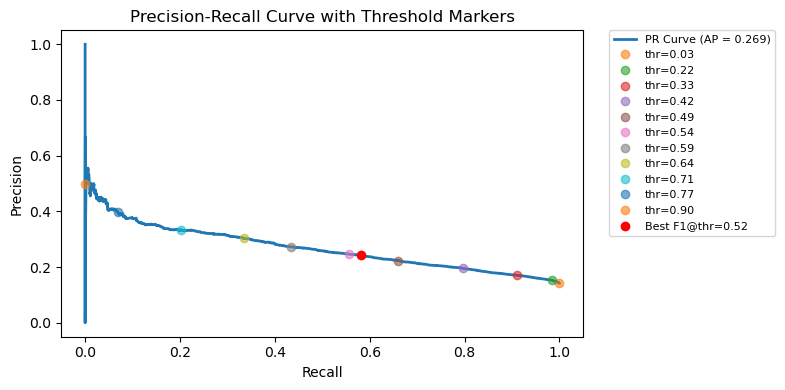

Best Threshold (Max F1): 0.524
Precision: 0.243, Recall: 0.582, F1: 0.343


In [107]:
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
ap_score = average_precision_score(y_true, y_proba)

# Compute F1 scores
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.3f})', linewidth=2)

# Add threshold markers every ~10 steps
step = len(thresholds) // 10
for i in range(0, len(thresholds), step):
    ax.plot(recall[i], precision[i], 'o', label=f"thr={thresholds[i]:.2f}", alpha=0.6)

ax.plot(recall[best_idx], precision[best_idx], 'ro', label=f'Best F1@thr={best_threshold:.2f}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve with Threshold Markers')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, borderaxespad=0.)

plt.tight_layout()
plt.show()

print(f"Best Threshold (Max F1): {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")


### Prediction on Test Data

In [124]:
y_test= test['defaulted']
y_proba = model.predict(train_cp)
y_train = train_cp['defaulted']
y_test_proba = model.predict(test)

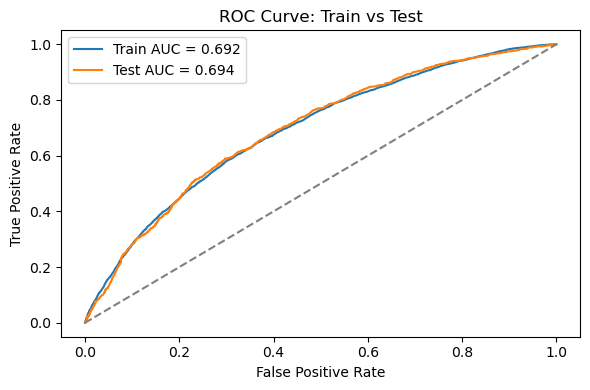

In [127]:
def plot_roc_train_test(y_train, train_probas, y_test, test_probas):
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probas)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probas)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_score(y_train, train_probas):.3f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_score(y_test, test_probas):.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Train vs Test')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc_train_test(y_train, y_proba, y_test, y_test_proba)

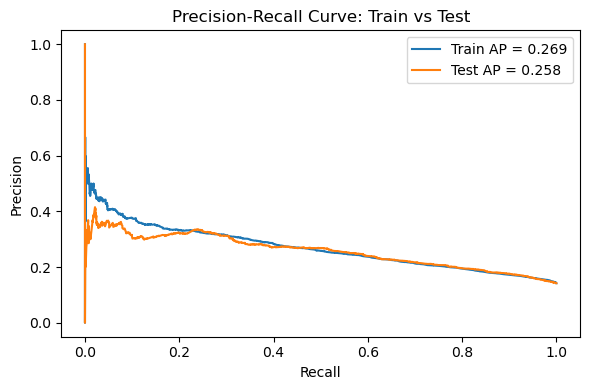

In [128]:
def plot_pr_train_test(y_train, train_probas, y_test, test_probas):
    prec_train, rec_train, _ = precision_recall_curve(y_train, train_probas)
    prec_test, rec_test, _ = precision_recall_curve(y_test, test_probas)

    plt.figure(figsize=(6, 4))
    plt.plot(rec_train, prec_train, label=f'Train AP = {average_precision_score(y_train, train_probas):.3f}')
    plt.plot(rec_test, prec_test, label=f'Test AP = {average_precision_score(y_test, test_probas):.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve: Train vs Test')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pr_train_test(y_train, y_proba, y_test, y_test_proba)

## Score Card and  Credit Score for Each Customer

After training a logistic regression model on the transformed dataset (with features already binned and encoded using Weight of Evidence), I used the predicted log-odds of default to compute credit scores. This approach is consistent with industry-standard credit scoring methodologies, where the score is linearly scaled from the model’s log-odds using a base score, and a Points to Double the Odds (**PDO**) value. The final score is calculated using the formula:

**Score = Offset – Factor × (log-odds),** 

where ``Factor = PDO / log(2)``.

This method is widely used because it produces interpretable, rank-ordered credit scores: a higher score indicates lower risk. It is closely aligned with the logic behind FICO and other bureau scores, which also rely on logistic models and WoE-style transformations for explainability, monotonicity, and stability over time. The monotonic relationship between score and risk makes it easier to implement policy decisions such as cutoffs and risk-based pricing. Overall, this method offers both statistical robustness and practical utility for credit risk evaluation.


To operationalize the scoring model, I constructed a scorecard from the logistic regression output. Each coefficient from the model—representing the contribution of a binned feature level—is scaled into a point value using the same linear transformation applied to the log-odds. The scorecard assigns these points to each attribute, and the total credit score for a borrower is computed by summing the points corresponding to their feature levels along with a base offset and intercept adjustment. This tabular format makes the model highly interpretable and auditable, as one can trace a borrower’s score back to individual feature contributions. Scorecards are a foundational tool in retail credit risk modeling and are particularly useful in regulated environments where transparency and explainability are essential.


## Scorecard

In [234]:
def scorecard(model, base_score=600, pdo=45):
    """
    Generate a scorecard with feature-level coefficients, p-values, and score points 
    from a fitted statsmodels Logit model.
    """
    factor = pdo / np.log(2)
    offset = base_score

    coefs = model.params.reset_index()
    pvals = model.pvalues.reset_index()

    coefs.columns = ['feature', 'coefficient']
    pvals.columns = ['feature', 'p_value']
    coefs = coefs.merge(pvals, on='feature')

    coefs['scorecard'] = (-factor * coefs['coefficient']).round(1)

    base_row = pd.DataFrame([['Base_Offset', np.nan, np.nan, round(offset, 1)]],
                            columns=['feature', 'coefficient', 'p_value', 'scorecard'])

    scorecard_df = pd.concat([base_row, coefs], ignore_index=True)

    return scorecard_df


In [236]:
scorecard(model)

,feature,coefficient,p_value,scorecard
0,Base_Offset,NaN,NaN,600.0
1,Intercept,1.565785,2.199999e-08,-101.7
2,C(int_rate)[T.Low_Risk],-0.386404,9.407913e-04,25.1
3,C(int_rate)[T.Medium_Risk],-0.252007,4.705721e-04,16.4
4,C(int_rate)[T.Very_High_Risk],0.006334,9.504965e-01,-0.4
5,C(int_rate)[T.Very_Low_Risk],-0.680216,7.101891e-05,44.2
6,C(term)[T. 60 months],0.624787,8.622085e-28,-40.6
7,C(sub_grade)[T.Low_Risk],-0.526856,1.919667e-03,34.2
8,C(sub_grade)[T.Medium_Low_Risk],-0.377792,1.136086e-02,24.5
9,C(sub_grade)[T.Medium_Risk],-0.120842,3.214458e-01,7.8


## Credit Score

In [237]:
def compute_credit_scores(model, data, base_score=600, pdo=45, odds_base=50):
    """
    Compute credit scores using statsmodels Logit model and formula.
    """
 
    log_odds = model.predict(data, linear=True)

    factor = pdo / np.log(2)
    offset = base_score #- factor * np.log(odds_base)

    scores = offset - factor * log_odds

    return pd.DataFrame(scores, index=data.index, columns=['CreditScore']).round(0)


In [238]:
train_credit = compute_credit_scores(model, train_cp)
test_credit = compute_credit_scores(model, test)

The minimum credit score is: 434.0
The maximum credit score is: 827.0
The mean credit score is: 612.1691300024005


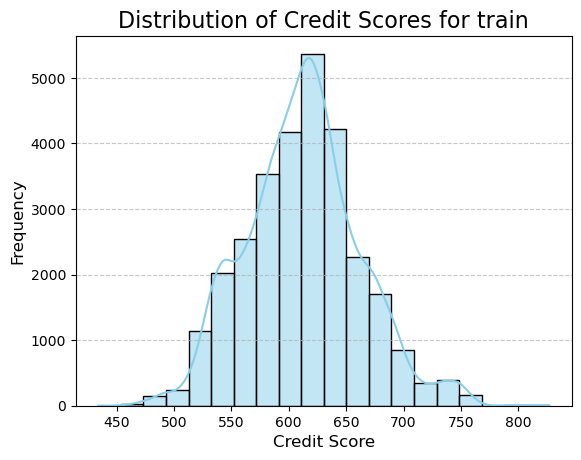

The minimum credit score is: 427.0
The maximum credit score is: 809.0
The mean credit score is: 612.7760516909541


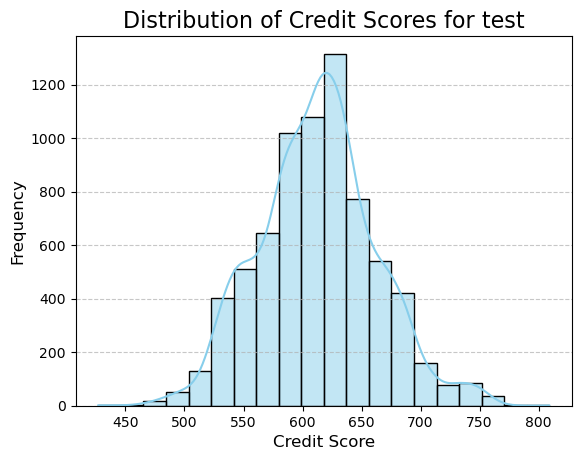

In [239]:
def his_credit_score(df, name):
    print(f'The minimum credit score is: {np.min(df)}')
    print(f'The maximum credit score is: {np.max(df)}')
    print(f'The mean credit score is: {np.mean(df)}')
    sns.histplot(data=df, x='CreditScore', bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Credit Scores for {name}', fontsize=16)
    plt.xlabel('Credit Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
his_credit_score(train_credit, 'train')
his_credit_score(test_credit, 'test')